In [51]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
import matplotlib.colors as colors
from matplotlib import rcParams 
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

pd.set_option('max_column',200)
plt.rc('font',size=25)
plt.rcParams.update({'figure.figsize': (6, 6),
                   'font.size':25,
                   'text.usetex':True,
                   'mathtext.default' : 'it',
                   'axes.labelsize': 32,
                   'legend.fontsize': 25,
                   'legend.fancybox': False,
                   'legend.numpoints': 1,
                   'xtick.labelsize': 32,
                   'ytick.labelsize': 32,
                   'ytick.major.width':0.8,
                   'ytick.major.size':8,
                   'ytick.minor.size':4,
                   'xtick.major.width': 0.8,
                   'xtick.major.size':8,
                   'xtick.minor.size':4,
                   'axes.linewidth':2,
                   'lines.linewidth':2,
                   'xtick.direction':'in',
                   'ytick.direction':'in',
                   'savefig.bbox': 'tight', # 'tight' or 'standard'.
                   'savefig.pad_inches' : 0.1})
plt.rc('font',**{'family':'serif','serif':['Computer Modern'],'sans-serif':['Computer Modern']})

from matplotlib.ticker import FuncFormatter
#%matplotlib inline

import glob

# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            medianBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [2]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

In [3]:
def fitrms(x, y, xMin, xMax, Nbin, verbose=1 ): 
    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    rmsBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            rmsBin[i] = rms(yAux) #rms
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            rmsBin[i] = np.nan
            sigGbin[0][i] = np.nan
            sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
    
    return xBin, nPts, rmsBin, sigGbin

In [4]:
def fitwe(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    weBin = 0*np.linspace(0, 1, Nbin)
#    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            weBin[i] = np.sqrt(yAux.size/sum(1/yAux**2)) #rms
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            #sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            #sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            #sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
            #sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
        else:
            nPts[i] = 0 
            weBin[i] = np.nan
            #sigGbin[0][i] = np.nan
            #sigGbin[1][i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
    
    return xBin, nPts, weBin

In [5]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitstd(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
#    medianBin = 0*np.linspace(0, 1, Nbin)
#    meanBin = 0*np.linspace(0, 1, Nbin)
    #std = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin)
#    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        
        if (yAux.size > 0):
            nPts[i] = yAux.size
           # medianBin[i] = np.median(yAux) 
           # meanBin[i] = np.mean(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#            sigGbin[0][i] = np.sqrt(np.pi/2)*sigmaG2/np.sqrt(nPts[i])
#            sigGbin[1][i] = np.sqrt(np.pi/2)*sigmaG1/np.sqrt(nPts[i])
            sigGbin[i]=(sigmaG1+sigmaG2)/2
            #std[i]= np.std(yAux)
        else:
            nPts[i] = 0 
            #medianBin[i] = np.nan
            #sigGbin[0][i] = np.nan
            sigGbin[i] = np.nan 
            # nPts[i], medianBin[i], sigGBin[i] = 0 
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]))

    return xBin, nPts, sigGbin


# galaxy recalibration

In [6]:
pwd='../dropbox/galaxy/'

In [7]:
mg=pd.read_csv('../Downloads/catalog/final/totalgalaxy.csv')

KeyboardInterrupt: 

In [7]:
mg=mg[mg.i_psfflux_mag-mg.i_cmodel_mag>0.15]

In [8]:

Znum=pd.read_csv('../Downloads/catalog/final/calibration/table/Znum.csv')
Zra=pd.read_csv('../Downloads/catalog/final/calibration/table/Zra.csv')
Zdec=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdec.csv')
Zrasem=pd.read_csv('../Downloads/catalog/final/calibration/table/Zrasem.csv')
Zdecsem=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdecsem.csv')
Zraerr=pd.read_csv('../Downloads/catalog/final/calibration/table/Zraerr.csv')
Zdecerr=pd.read_csv('../Downloads/catalog/final/calibration/table/Zdecerr.csv')

In [12]:
def cali_star(i):#for i in range(len(x)-1): #columns, ra
    print(i)
    t=[]
    for j in range(len(y)-1): #rows, dec
        tt=mg[(mg.i_sdsscentroid_ra<x[i+1])&(mg.i_sdsscentroid_ra>x[i])&(mg.i_sdsscentroid_dec>y[j])&(mg.i_sdsscentroid_dec<y[j+1])].copy()
        if len(tt)==0:
            continue
        tt['pmra_cl']=tt.pmra-Zra.iloc[j,i]
        tt['pmdec_cl']=tt.pmdec-Zdec.iloc[j,i]
        t.append(tt)
        
    if len(t)!=0:
        ttt=pd.concat(t)
        print(i,'-')
        return ttt
    else:
        print(i,'-0')
        return tt

In [13]:
x=np.arange(-30,36.05,0.05)#1320
y=np.arange(-1.25,1.3,0.05)#50

In [14]:
pool1=mp.Pool(12)
data=pool1.map(cali_star,range(len(x)-1))
pool1.close()

0
28
56
84
112
140
168
224
196
280
308
252
0 -
196 -
28 -
112 -
84 -
280 -
168 -
308 -
140 -
1
56 -
252 -
197
85
113
29
224 -
281
169
141
309
57
253
225
197 -
1 -
281 -
113 -
198
2
282
114
253 -
169 -
141 -
85 -
57 -
309 -
29 -
254
170
142
86
58
310
30
225 -
226
198 -
282 -
199
283
2 -
58 -
114 -
254 -
86 -
30 -
3
59
142 -
115
255
87
310 -
31
143
170 -
311
226 -
171
227
283 -
3 -
284
199 -
115 -
59 -
87 -
4
200
116
143 -
60
255 -
88
31 -
311 -
144
256
171 -
32
312
172
227 -
228
4 -
5
284 -
285
200 -
144 -
60 -
116 -
201
145
88 -
61
117
256 -
89
257
172 -
32 -
228 -
312 -
173
33
229
313
5 -
6
201 -
285 -
202
286
117 -
61 -
145 -
89 -
118
62
90
146
257 -
173 -
258
174
229 -
33 -
313 -
230
34
314
6 -
7
286 -
202 -
287
90 -
203
62 -
118 -
91
63
119
258 -
146 -
259
174 -
230 -
147
34 -
175
231
314 -
35
315
7 -
203 -
8
204
287 -
91 -
288
63 -
92
119 -
64
120
259 -
260
147 -
175 -
231 -
148
176
232
315 -
35 -
316
36
8 -
64 -
288 -
204 -
9
65
289
205
92 -
93
120 -
121
260 -
148 -
176 -
261
149

881
908 -0
909
741 -0
742
769 -0
770
936 -
937
797 -0
798
825 -0
826
964 -
965
686 -0
687
992 -
993
853 -0
854
714 -0
715
881 -0
882
909 -0
910
742 -0
743
770 -0
771
937 -
938
798 -0
799
826 -0
827
965 -
966
687 -0
688
993 -
994
854 -0
855
715 -0
716
882 -0
883
910 -
911
743 -0
744
771 -0
772
938 -
939
799 -0
800
827 -0
828
966 -
967
688 -0
689
994 -
995
855 -0
856
716 -0
717
883 -0
884
911 -
912
744 -0
745
772 -0
773
939 -
940
800 -0
801
828 -0
829
967 -
689 -0
968
690
995 -
996
856 -0
857
717 -0
718
884 -0
885
912 -
913
745 -0
746
773 -0
774
940 -
941
801 -0
802
829 -0
830
690 -0
691
968 -
969
996 -
997
857 -0
858
718 -0
719
885 -0
886
913 -
914
746 -0
747
774 -0
775
941 -
942
802 -0
803
830 -0
831
691 -0
692
969 -
970
997 -
998
858 -0
859
719 -0
720
886 -0
887
914 -
915
747 -0
748
775 -0
776
942 -
943
803 -0
831 -0
804
832
692 -0
693
970 -
971
998 -
999
859 -0
860
720 -0
721
887 -0
888
915 -
916
748 -0
749
776 -0
777
943 -
944
832 -0
833
693 -0
804 -0
694
805
971 -
972
999 -
1000
86

In [15]:
mg=pd.concat(data)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [16]:
len(mg)

3081731

In [8]:
mg=pd.read_csv('../Downloads/catalog/final/galaxyfordispersion.csv')

In [10]:
#mg1=mg[mg.i_psfflux_mag-mg.i_cmodel_mag<0.4]
mg2=mg[mg.i_psfflux_mag-mg.i_cmodel_mag<0.3]

## getting pml,pmb

In [18]:
mg3=mg

In [19]:
rag=mg3.i_sdsscentroid_ra.values
decg=mg3.i_sdsscentroid_dec.values
pmrag=mg3.pmra_cl.values
pmdecg=mg3.pmdec_cl.values

In [20]:
t=SkyCoord(ra=rag*u.degree, dec=decg*u.degree, pm_ra_cosdec=pmrag*u.mas/u.year, pm_dec=pmdecg*u.mas/u.year, frame='icrs')

In [21]:
mg['l']=t.galactic.l
mg['b']=t.galactic.b
mg['pmlcosb']=t.galactic.pm_l_cosb
mg['pmb']=t.galactic.pm_b

In [23]:
mg.to_csv('../Downloads/catalog/final/galaxyfordispersion.csv',index=False)

# quasar recalibration

In [15]:
mq=pd.read_csv('../Downloads/catalog/final/matchedquasar2.csv')

In [16]:
mg3=mq
rag=mg3.i_sdsscentroid_ra.values
decg=mg3.i_sdsscentroid_dec.values
pmrag=mg3.pmra_cl.values
pmdecg=mg3.pmdec_cl.values

In [17]:
t=SkyCoord(ra=rag*u.degree, dec=decg*u.degree, pm_ra_cosdec=pmrag*u.mas/u.year, pm_dec=pmdecg*u.mas/u.year, frame='icrs')

In [18]:
mq['l']=t.galactic.l
mq['b']=t.galactic.b
mq['pmlcosb']=t.galactic.pm_l_cosb
mq['pmb']=t.galactic.pm_b

In [20]:
mq.to_csv('../Downloads/catalog/final/matchedquasar2.csv',index=False)

# bootstrap

In [12]:
def bts(s,nsamp): #t: sample, nsamp: number of sub-sample
    n=len(s)#total number
    abts=np.zeros((nsamp,n))#subsample array
    for i in range(nsamp):#generate nsamp subsamples
        ran=np.random.rand(n)#generate random number for n times for each subsample
        for j in range(n):#select the element in sample
            select=np.ceil(ran[j]*(n))
            abts[i,j]=s[int(select)-1]
    return abts

In [13]:
# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def vd(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    meanBin = 0*np.linspace(0, 1, Nbin)
    std = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin)
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            a=bts(yAux,200)#bootsrap
            #btsmean=[]
            btssig=[]
            for j in range(len(a)):
                #btsmean.append(np.mean(a[j]))
                btssig.append(0.741*(np.percentile(a[j],75)-np.percentile(a[j],25)))
            sigGbin[i]= 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))#use the original dispersion
            std[i] = np.std(btssig)
        else:
            nPts[i] = 0 
            sigGbin[i] = np.nan 
            std[i] = np.nan

    return xBin, nPts, sigGbin, std

# fitting

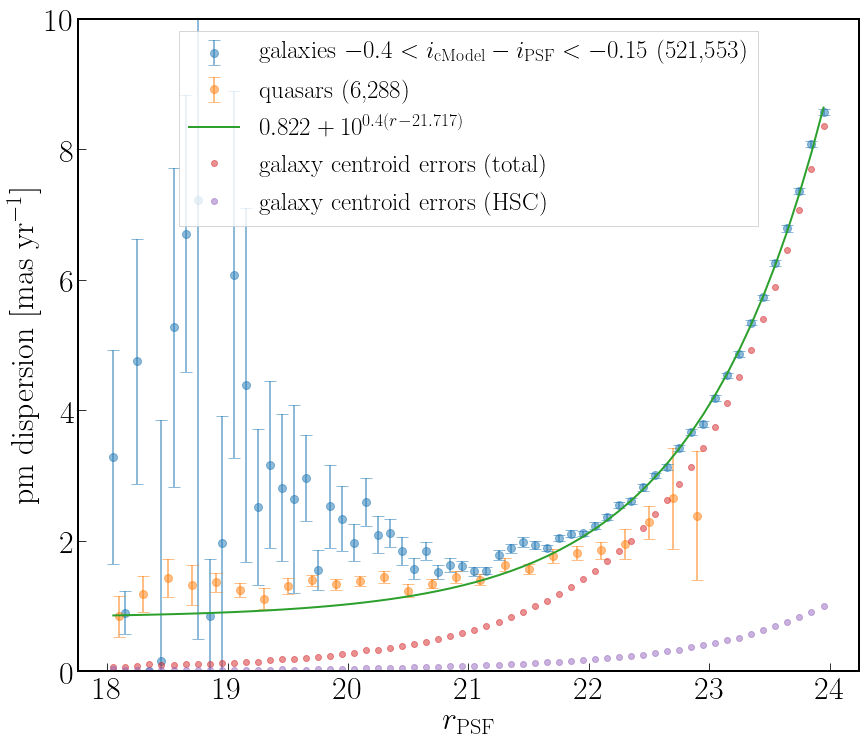

In [27]:
plt.figure(figsize=(14,12))
#x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg1.psfMag_r.values, mg1.pmra_cl.values, 18, 24, 60, 0)
a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.4<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg1),','))+')')

#x2Bin0, n2Pts0, s2igGbin0, std20 = vd(mq.psfMag_r.values, mq.pmra_cl.values, 18, 24, 30, 0)
a2=plt.errorbar(x2Bin0,s2igGbin0,std20,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'quasars (6,288)')

def pmd(mag,y0,r0):
    return y0+10**(0.4*(mag-r0))

y1=s1igGbin0[-20:]
x1=x1Bin0[-20:]
#x1=np.append(x1,x1Bin0[-20:])
#y1=np.append(y1,s1igGbin0[-20:])
sig1=std10[-20:]
#sig1=np.append(sig1,std10[-20:])
popt1,pcov1=curve_fit(pmd,x1,y1,sigma=sig1)
a3=plt.errorbar(x1Bin0,pmd(x1Bin0,*popt1),label=r'$%0.3f+10^{0.4(r-%0.3f)}$'%(round(popt1[0],3),round(popt1[1],3)))
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg1.psfMag_r, mg1.pmra_err, 18, 24, 60, 0)
a4=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (total)')
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg1.psfMag_r, mg1.i_sdsscentroid_rasigma*1000/mg1.delta_yr, 18, 24, 60, 0)
a5=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (HSC)')
#H=[a1,a2,a3,a4]
plt.legend()
plt.ylim(0,10)
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('$r_{\mathrm{PSF}}$')
plt.savefig(pwd+'pm_ra_fitting_error_quasar.pdf')

In [55]:
len(mg[mg.psfMag_r<24])

2448752

In [64]:
len(mq[(mq.psfMag_r<24)&(mq.psfMag_r>18)])

6279

Text(0.5, 0, '$r_{\\mathrm{PSF}}$')

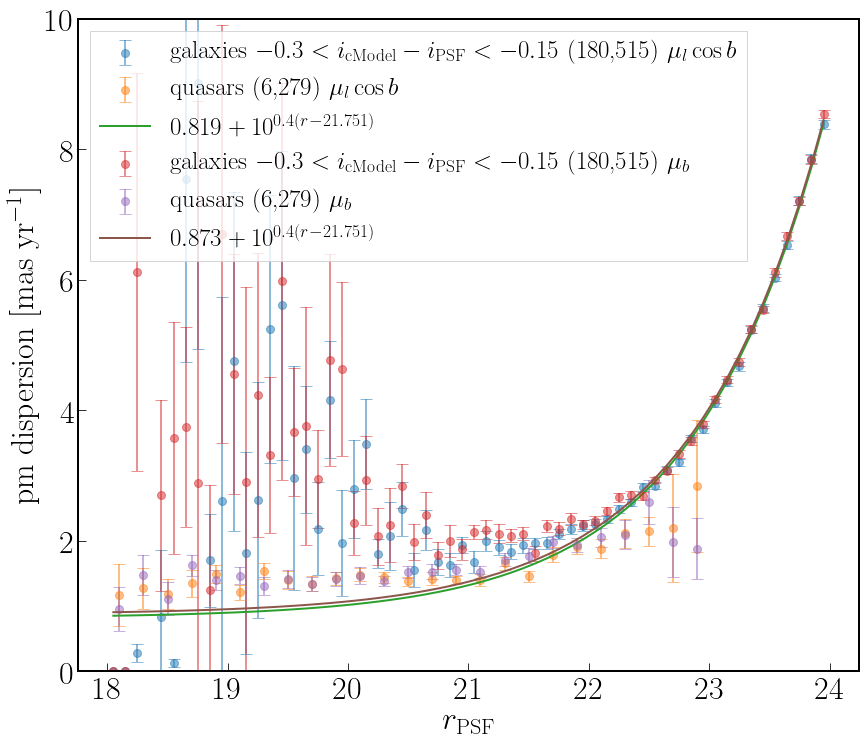

In [23]:
plt.figure(figsize=(14,12))
x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg2.psfMag_r.values, mg2.pmlcosb.values, 18, 24, 60, 0)
a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.3<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg2[(mg2.psfMag_r<24)&(mg2.psfMag_r>18)]),','))+r') $\mu_l\cos b$')
#x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg2.psfMag_r.values, mg2.pmb.values, 18, 24, 60, 0)
#a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.3<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg2[(mg2.psfMag_r<24)&(mg2.psfMag_r>18)]),','))+')')

x2Bin0, n2Pts0, s2igGbin0, std20 = vd(mq.psfMag_r.values, mq.pmlcosb.values, 18, 24, 30, 0)
a2=plt.errorbar(x2Bin0,s2igGbin0,std20,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'quasars (6,279) $\mu_l\cos b$')

def pmd(mag,y0,r0):
    return y0+10**(0.4*(mag-r0))

y1=s1igGbin0[-20:]
x1=x1Bin0[-20:]
#x1=np.append(x1,x1Bin0[-20:])
#y1=np.append(y1,s1igGbin0[-20:])
sig1=std10[-20:]
#sig1=np.append(sig1,std10[-20:])
popt1,pcov1=curve_fit(pmd,x1,y1,sigma=sig1)
a3=plt.errorbar(x1Bin0,pmd(x1Bin0,*popt1),label=r'$%0.3f+10^{0.4(r-%0.3f)}$'%(round(popt1[0],3),round(popt1[1],3)))
#x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg2.psfMag_r, mg2.pmra_err, 18, 24, 60, 0)
#a4=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (total)')
#x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg2.psfMag_r, mg2.i_sdsscentroid_rasigma*1000/mg2.delta_yr, 18, 24, 60, 0)
#a5=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (HSC)')
x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg2.psfMag_r.values, mg2.pmb.values, 18, 24, 60, 0)
a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.3<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg2[(mg2.psfMag_r<24)&(mg2.psfMag_r>18)]),','))+r') $\mu_b$')
#x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg2.psfMag_r.values, mg2.pmb.values, 18, 24, 60, 0)
#a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.3<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg2[(mg2.psfMag_r<24)&(mg2.psfMag_r>18)]),','))+')')

x2Bin0, n2Pts0, s2igGbin0, std20 = vd(mq.psfMag_r.values, mq.pmb.values, 18, 24, 30, 0)
a2=plt.errorbar(x2Bin0,s2igGbin0,std20,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'quasars (6,279) $\mu_b$')

def pmd(mag,y0,r0):
    return y0+10**(0.4*(mag-r0))

y1=s1igGbin0[-20:]
x1=x1Bin0[-20:]
#x1=np.append(x1,x1Bin0[-20:])
#y1=np.append(y1,s1igGbin0[-20:])
sig1=std10[-20:]
#sig1=np.append(sig1,std10[-20:])
popt1,pcov1=curve_fit(pmd,x1,y1,sigma=sig1)
a3=plt.errorbar(x1Bin0,pmd(x1Bin0,*popt1),label=r'$%0.3f+10^{0.4(r-%0.3f)}$'%(round(popt1[0],3),round(popt1[1],3)))
#H=[a1,a2,a3,a4]
plt.legend()
plt.ylim(0,10)
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('$r_{\mathrm{PSF}}$')
#plt.savefig(pwd+'pm_ra_fitting_error_quasar_final.pdf')

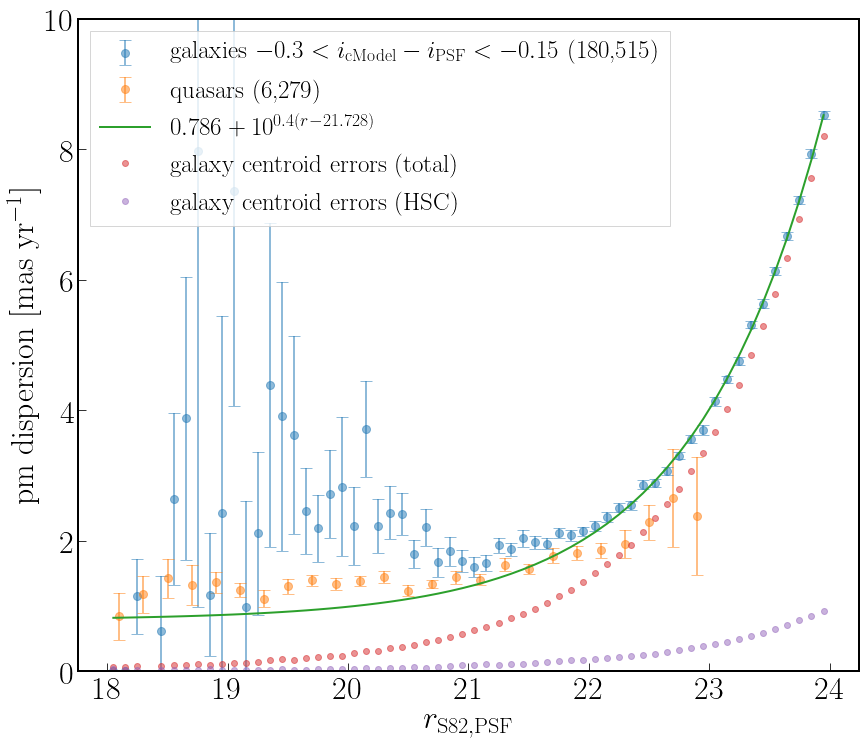

In [88]:
plt.figure(figsize=(14,12))
x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg2.psfMag_r.values, mg2.pmra_cl.values, 18, 24, 60, 0)
a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.3<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg2[(mg2.psfMag_r<24)&(mg2.psfMag_r>18)]),','))+')')

x2Bin0, n2Pts0, s2igGbin0, std20 = vd(mq.psfMag_r.values, mq.pmra_cl.values, 18, 24, 30, 0)
a2=plt.errorbar(x2Bin0,s2igGbin0,std20,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'quasars (6,279)')

def pmd(mag,y0,r0):
    return y0+10**(0.4*(mag-r0))

y1=s1igGbin0[-20:]
x1=x1Bin0[-20:]
#x1=np.append(x1,x1Bin0[-20:])
#y1=np.append(y1,s1igGbin0[-20:])
sig1=std10[-20:]
#sig1=np.append(sig1,std10[-20:])
popt1,pcov1=curve_fit(pmd,x1,y1,sigma=sig1)
a3=plt.errorbar(x1Bin0,pmd(x1Bin0,*popt1),label=r'$%0.3f+10^{0.4(r-%0.3f)}$'%(round(popt1[0],3),round(popt1[1],3)))
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg2.psfMag_r, mg2.pmra_err, 18, 24, 60, 0)
a4=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (total)')
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg2.psfMag_r, mg2.i_sdsscentroid_rasigma*1000/mg2.delta_yr, 18, 24, 60, 0)
a5=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (HSC)')
#H=[a1,a2,a3,a4]
plt.legend()
plt.ylim(0,10)
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('$r_{\mathrm{S82,PSF}}$')
plt.savefig(pwd+'pm_ra_fitting_error_quasar_final.pdf')

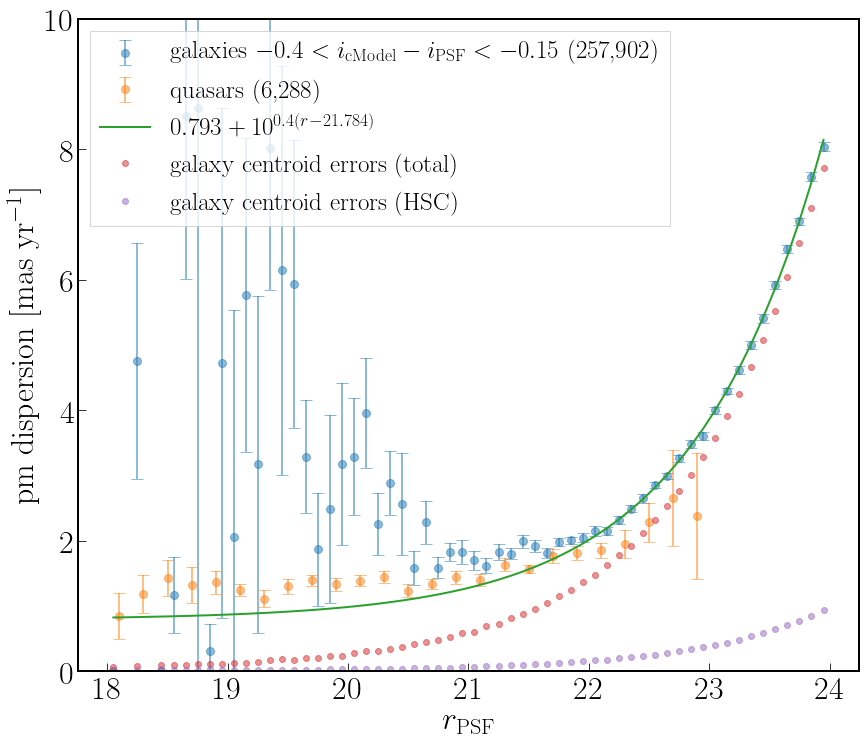

In [41]:
plt.figure(figsize=(14,12))
x1Bin0, n1Pts0, s1igGbin0, std10 = vd(mg3.psfMag_r.values, mg3.pmra_cl.values, 18, 24, 60, 0)
a1=plt.errorbar(x1Bin0,s1igGbin0,std10,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'galaxies $-0.4<i_{\rm cModel}-i_{\rm PSF}<-0.15$ ('+str(format(len(mg3),','))+')')

x2Bin0, n2Pts0, s2igGbin0, std20 = vd(mq.psfMag_r.values, mq.pmra_cl.values, 18, 24, 30, 0)
a2=plt.errorbar(x2Bin0,s2igGbin0,std20,alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'quasars (6,288)')

def pmd(mag,y0,r0):
    return y0+10**(0.4*(mag-r0))

y1=s1igGbin0[-20:]
x1=x1Bin0[-20:]
#x1=np.append(x1,x1Bin0[-20:])
#y1=np.append(y1,s1igGbin0[-20:])
sig1=std10[-20:]
#sig1=np.append(sig1,std10[-20:])
popt1,pcov1=curve_fit(pmd,x1,y1,sigma=sig1)
a3=plt.errorbar(x1Bin0,pmd(x1Bin0,*popt1),label=r'$%0.3f+10^{0.4(r-%0.3f)}$'%(round(popt1[0],3),round(popt1[1],3)))
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg3.psfMag_r, mg3.pmra_err, 18, 24, 60, 0)
a4=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (total)')
x2Bin, n2Pts, m2edianBin, s2igGbin = fitMedians(mg3.psfMag_r, mg3.i_sdsscentroid_rasigma*1000/mg3.delta_yr, 18, 24, 60, 0)
a5=plt.errorbar(x2Bin,m2edianBin,alpha=0.5,fmt='o',label=r'galaxy centroid errors (HSC)')
#H=[a1,a2,a3,a4]
plt.legend()
plt.ylim(0,10)
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('$r_{\mathrm{PSF}}$')
plt.savefig(pwd+'pm_ra_fitting_error_quasar3.pdf')

# interpolation

In [43]:
len(mg2),len(mq)

(279941, 6288)

In [24]:
ms=pd.read_csv('../Downloads/catalog/final/4/starall_sm.csv')

In [45]:
len(ms)

596217

In [25]:
def clip(t,x, y, xMin, xMax, Nbin, verbose=1): 
    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = [-1+0*np.linspace(0, 1, Nbin),-1+0*np.linspace(0, 1, Nbin)] #lower and upper
    tt=[]
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        t1 = t[(x>xEdge[i])&(x<=xEdge[i+1])]
        yAux1 = y[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = ye[(x>xEdge[i])&(x<=xEdge[i+1])]
#        yErr = yErr[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
        if (yAux1.size > 0):
            yAux = yAux1#[(yAux1<np.percentile(yAux1,99.85))&(yAux1>np.percentile(yAux1,0.15))]#3sigma clipping
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux) #mean
            # robust estimate of standard deviation: 0.741*(q75-q50),0.741*(q50-q25)
            sigmaG1 = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,50))*2
            sigmaG2 = 0.741*(np.percentile(yAux,50)-np.percentile(yAux,25))*2
            t1=t1[(yAux<np.median(yAux)+3*sigmaG1)&(yAux>np.median(yAux)-3*sigmaG2)]
            tt.append(t1)
    tt=pd.concat(tt)
    return tt

In [26]:
tt=clip(ms,ms.gi,ms.gr, 0, 4, 400, 0)

In [27]:
tt=tt[(tt.psfMag_r<24)&(tt.psfMag_r>18)]

In [28]:
mb=tt[(tt.gr<0.6)]#&(ms.gr>0.2)]
mr=tt[(tt.gr>0.6)]#&(ms.gr<1.6)]
len(tt),len(mb),len(mr)

(491961, 94993, 396968)

In [29]:
def inter(x,a,b):
    return (b-a)/0.1*x+a

In [37]:
x1Bin1, n1Pts1, s1igGbin1= fitstd(mg2.psfMag_r.values, mg2.pmra_cl.values, 22, 24, 20, 0)
x1Bin2, n1Pts2, s1igGbin2= fitstd(mg2.psfMag_r.values, mg2.pmdec_cl.values, 22, 24, 20, 0)
x1Bin3, n1Pts3, s1igGbin3= fitstd(mq.psfMag_r.values, mq.pmra_cl.values, 18, 22, 20, 0)
x1Bin4, n1Pts4, s1igGbin4= fitstd(mq.psfMag_r.values, mq.pmdec_cl.values, 18, 22, 20, 0)
x1Bin12, n1Pts12, s1igGbin12= fitstd(mg2.psfMag_r.values, mg2.pmlcosb.values, 22, 24, 20, 0)
x1Bin22, n1Pts22, s1igGbin22= fitstd(mg2.psfMag_r.values, mg2.pmb.values, 22, 24, 20, 0)
x1Bin32, n1Pts32, s1igGbin32= fitstd(mq.psfMag_r.values, mq.pmlcosb.values, 18, 22, 20, 0)
x1Bin42, n1Pts42, s1igGbin42= fitstd(mq.psfMag_r.values, mq.pmb.values, 18, 22, 20, 0)

In [38]:
x1=np.append(x1Bin3,x1Bin1)
y1=np.append(s1igGbin3,s1igGbin1)
y2=np.append(s1igGbin4,s1igGbin2)
y12=np.append(s1igGbin32,s1igGbin12)
y22=np.append(s1igGbin42,s1igGbin22)

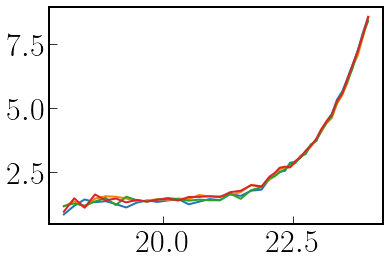

In [39]:
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.plot(x1,y12)
plt.plot(x1,y22)

In [40]:
ti=[]
t=tt[(tt.psfMag_r<=x1[0])]
t['pmra_dis_err']=inter(t.psfMag_r-x1[0],y1[0],y1[1])
t['pmdec_dis_err']=inter(t.psfMag_r-x1[0],y2[0],y2[1])
t['pmlcosb_dis_err']=inter(t.psfMag_r-x1[0],y12[0],y12[1])
t['pmb_dis_err']=inter(t.psfMag_r-x1[0],y22[0],y22[1])
ti.append(t)
for i in range(len(x1)-1):
    t=tt[(tt.psfMag_r>x1[i])&(tt.psfMag_r<=x1[i+1])]
    t['pmra_dis_err']=inter(t.psfMag_r-x1[i],y1[i],y1[i+1])
    t['pmdec_dis_err']=inter(t.psfMag_r-x1[i],y2[i],y2[i+1])
    t['pmlcosb_dis_err']=inter(t.psfMag_r-x1[i],y12[i],y12[i])
    t['pmb_dis_err']=inter(t.psfMag_r-x1[i],y22[i],y22[i])
    ti.append(t)
t=tt[(tt.psfMag_r>x1[39])]
t['pmra_dis_err']=inter(t.psfMag_r-x1[38],y1[38],y1[39])
t['pmdec_dis_err']=inter(t.psfMag_r-x1[38],y2[38],y2[39])
t['pmlcosb_dis_err']=inter(t.psfMag_r-x1[38],y12[38],y12[39])
t['pmb_dis_err']=inter(t.psfMag_r-x1[38],y22[38],y22[39])
ti.append(t)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [41]:
ttt=pd.concat(ti)

In [42]:
len(ttt)

491961

In [43]:
ttt['vra_dis_err']=ttt.pmra_dis_err*ttt.Dkpc/3600*3.261564*300000*np.pi/180
ttt['vdec_dis_err']=ttt.pmdec_dis_err*ttt.Dkpc/3600*3.261564*300000*np.pi/180
ttt['vl_dis_err']=ttt.pmlcosb_dis_err*ttt.Dkpc/3600*3.261564*300000*np.pi/180
ttt['vb_dis_err']=ttt.pmb_dis_err*ttt.Dkpc/3600*3.261564*300000*np.pi/180

In [44]:
mb=ttt[(ttt.gr<0.6)]#&(ms.gr>0.2)]
mr=ttt[(ttt.gr>0.6)]#&(ms.gr<1.6)]
len(ttt),len(mb),len(mr)

(491961, 94993, 396968)

In [46]:
ttt.to_csv('../Downloads/catalog/final/starfordispersion.csv',index=False)

# dispersion

In [59]:
pwd='../dropbox/dispersion/'

## no magnitude dependence

In [202]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
t=ttt
for i in range(4):
    ta=t[(t.i_psfflux_mag>22+i*0.25)&(t.i_psfflux_mag<22.25+i*0.25)]
    D = ta.Dkpc.values
    vra = ta.pmra_cl_sm.values
    vdec = ta.pmdec_cl_sm.values
    x1Bin, n1Pts, s1igGbin= fitstd(D, vra, 0, 40, 40, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    x1Bin, n1Pts, s1igGbin= fitstd(D, vdec, 0, 40, 40, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    
    vra = ta.pmra_dis_err.values
    vdec= ta.pmdec_dis_err.values
    xBin, nPts, medianBin, sigGbin= fitMedians(D, vra, 0, 40, 40, 0)
    x.append(xBin)
    y3.append(medianBin)
    xBin, nPts, medianBin, sigGbin= fitMedians(D, vdec, 0, 40, 40, 0)
    x.append(xBin)
    y4.append(medianBin)



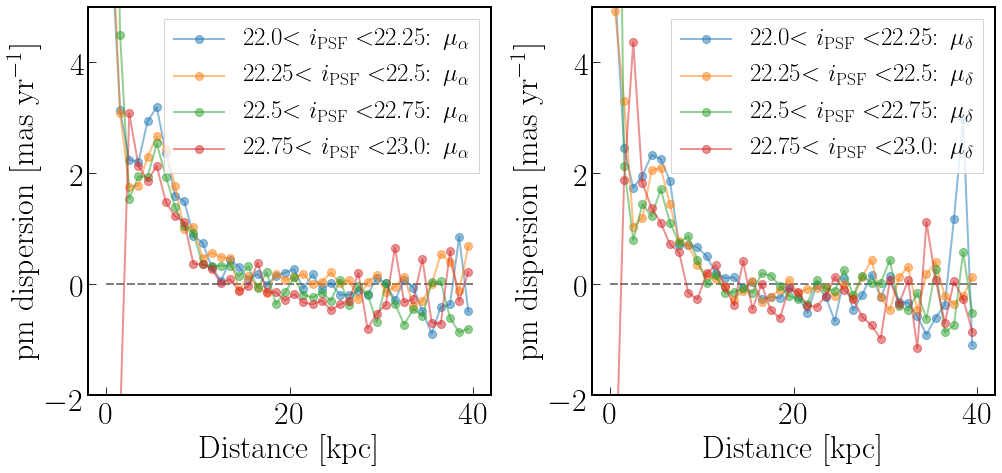

In [203]:
plt.figure(figsize=(14,6))
plt.axes([0.05,0.05,0.4,0.9])
for i in range(4):
    #plt.title('$i_{\rm PSF}<$'+str(round(22.4+j*0.6,3)))
    plt.errorbar(x[i],y1[i]-y3[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    #plt.errorbar(x[i],y2[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    plt.hlines(0,0,40,linestyle='dashed',color='grey')
#plt.text(15,10,'fitting with stars in [20,40] kpc')
plt.legend()
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('Distance [kpc]')
plt.ylim(-2,5)

plt.axes([0.55,0.05,0.4,0.9])
for i in range(4):
    #plt.title('$i_{\rm PSF}<$'+str(round(22.4+j*0.6,3)))
    plt.errorbar(x[i],y2[i]-y4[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\delta$')
    #plt.errorbar(x[i],y2[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    plt.hlines(0,0,40,linestyle='dashed',color='grey')
#plt.text(15,10,'fitting with stars in [20,40] kpc')
plt.legend()
plt.ylabel('pm dispersion [mas yr$^{-1}$]')
plt.xlabel('Distance [kpc]')
plt.ylim(-2,5)
plt.savefig(pwd+'pm_ra_dec_mag.pdf')

In [209]:
ttt.columns

Index(['# object_id', 'i_extendedness_value', 'ra_1', 'dec_1',
       'r_extendedness_value', 'i_sdsscentroid_ra', 'i_sdsscentroid_dec',
       'i_sdsscentroid_rasigma', 'i_sdsscentroid_decsigma', 'g_cmodel_mag',
       ...
       'v_b', 'v_lcosb', 'v_ra_sm', 'v_dec_sm', 'v_b_sm', 'v_lcosb_sm',
       'pmra_dis_err', 'pmdec_dis_err', 'vra_dis_err', 'vdec_dis_err'],
      dtype='object', length=119)

In [210]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
t=ttt
for i in range(4):
    ta=t[(t.i_psfflux_mag>22+i*0.25)&(t.i_psfflux_mag<22.25+i*0.25)]
    D = ta.Dkpc.values
    vra = ta.v_ra_sm.values
    vdec = ta.v_dec_sm.values
    x1Bin, n1Pts, s1igGbin= fitstd(D, vra, 0, 40, 40, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    x1Bin, n1Pts, s1igGbin= fitstd(D, vdec, 0, 40, 40, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    
    vra = ta.vra_dis_err.values
    vdec= ta.vdec_dis_err.values
    xBin, nPts, medianBin, sigGbin= fitMedians(D, vra, 0, 40, 40, 0)
    x.append(xBin)
    y3.append(medianBin)
    xBin, nPts, medianBin, sigGbin= fitMedians(D, vdec, 0, 40, 40, 0)
    x.append(xBin)
    y4.append(medianBin)




Text(0.5, 0, 'Distance [kpc]')

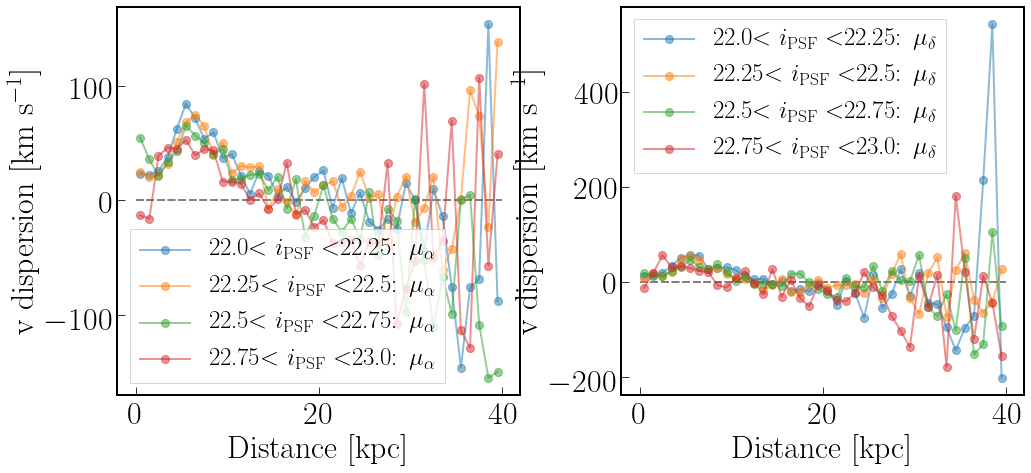

In [214]:
plt.figure(figsize=(14,6))
plt.axes([0.05,0.05,0.4,0.9])
for i in range(4):
    #plt.title('$i_{\rm PSF}<$'+str(round(22.4+j*0.6,3)))
    plt.errorbar(x[i],y1[i]-y3[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    #plt.errorbar(x[i],y2[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    plt.hlines(0,0,40,linestyle='dashed',color='grey')
#plt.text(15,10,'fitting with stars in [20,40] kpc')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.ylim(-2,5)

plt.axes([0.55,0.05,0.4,0.9])
for i in range(4):
    #plt.title('$i_{\rm PSF}<$'+str(round(22.4+j*0.6,3)))
    plt.errorbar(x[i],y2[i]-y4[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\delta$')
    #plt.errorbar(x[i],y2[i],alpha=0.5,marker='o',capsize=6, markersize=8, label=str(round(22+i*0.25,2))+r'$<i_{\rm PSF}<$'+str(round(22.25+i*0.25,2))+r': $\mu_\alpha$')
    plt.hlines(0,0,40,linestyle='dashed',color='grey')
#plt.text(15,10,'fitting with stars in [20,40] kpc')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.ylim(-2,5)
#plt.savefig(pwd+'pm_ra_dec_mag.pdf')

## velocity dispersion

In [388]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
ta=mr
print(len(ta[ta.Dkpc<40]))
D = ta.Dkpc.values
vra = ta.v_ra_sm.values
vdec = ta.v_dec_sm.values
x1Bin, n1Pts, s1igGbin= fitstd(D, vra, 0, 40, 40, 0)
x.append(x1Bin)
y1.append(s1igGbin)
x1Bin, n1Pts, s1igGbin= fitstd(D, vdec, 0, 40, 40, 0)
x.append(x1Bin)
y2.append(s1igGbin)

vra = ta.vra_dis_err.values
vdec= ta.vdec_dis_err.values
xBin, nPts, medianBin= fitwe(D, vra, 0, 40, 40, 0)
x.append(xBin)
#y3.append(medianBin)
y3.append(np.sqrt(medianBin**2+10000))
xBin, nPts, medianBin= fitwe(D, vdec, 0, 40, 40, 0)
x.append(xBin)
#y4.append(medianBin)
y4.append(np.sqrt(medianBin**2+10000))





396967


$\frac{\sum_i w_i*\sigma_i^2}{\sum_i w_i}$

Text(0.5, 0, 'Distance [kpc]')

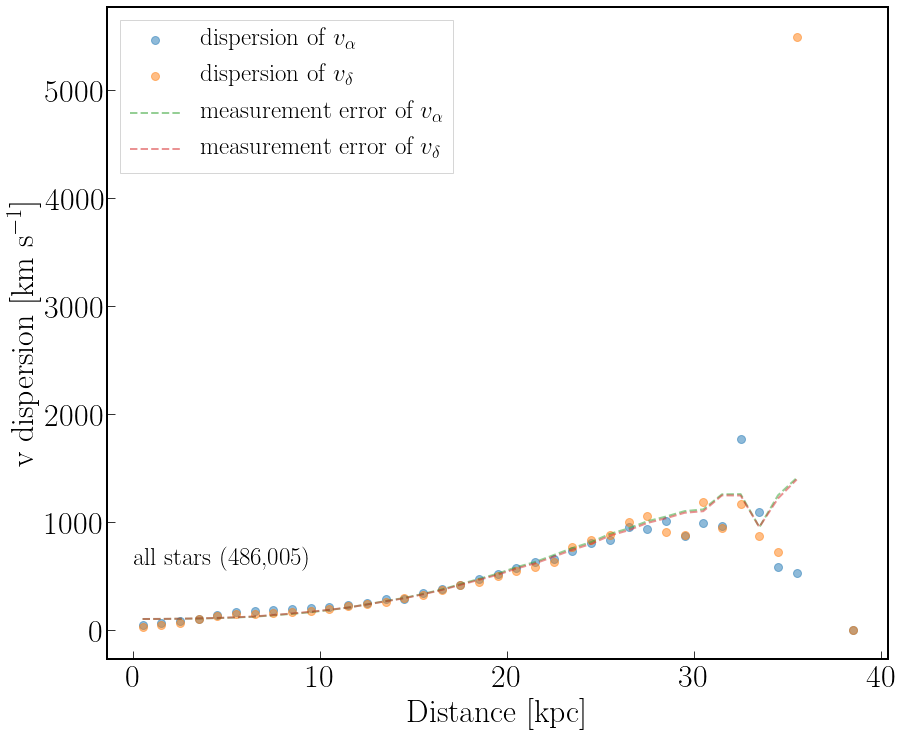

In [389]:

plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.savefig(pwd+'all_v_ra_dec.pdf')

$\frac{\sum_i w_i*\sigma_i}{\sum_i w_i}$

Text(0.5, 0, 'Distance [kpc]')

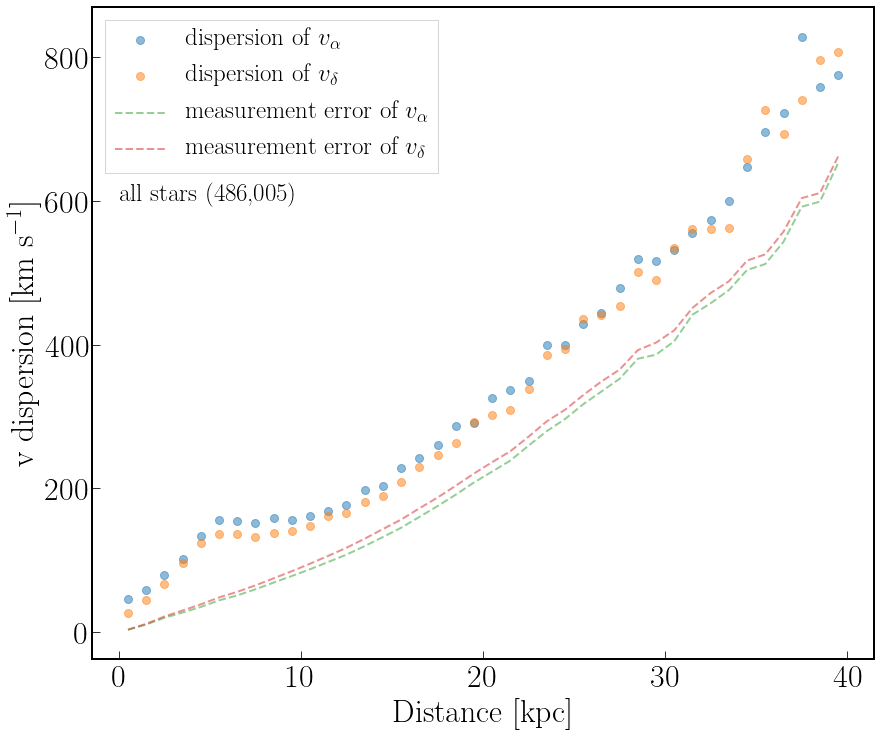

In [284]:

plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.savefig(pwd+'all_v_ra_dec.pdf')

$\sqrt(100^2+(\frac{\sum_i w_i*\sigma_i}{\sum_i w_i})^2)$

Text(0.5, 0, 'Distance [kpc]')

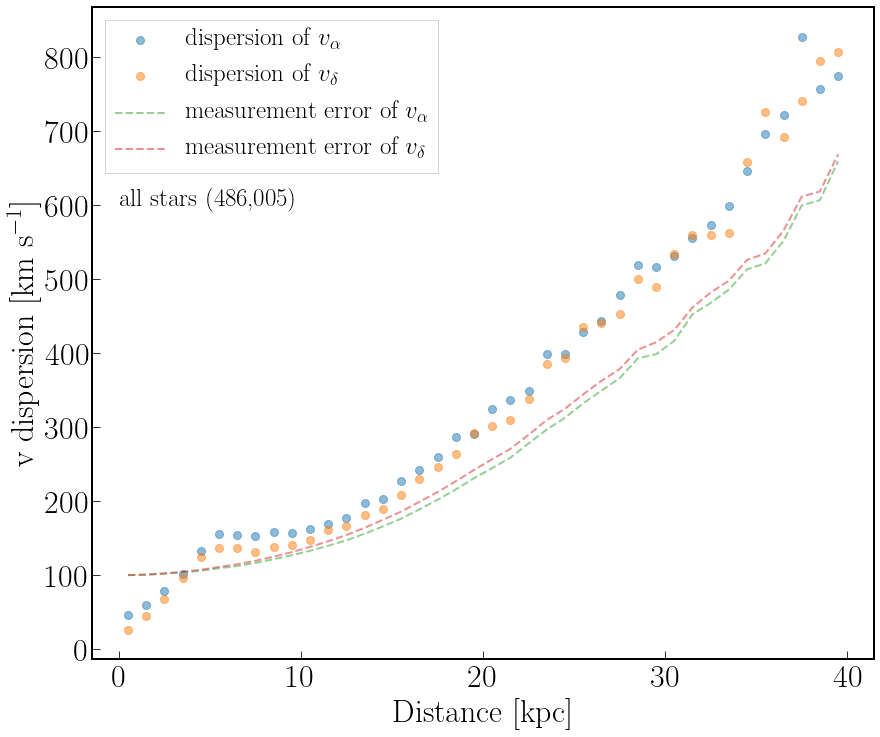

In [282]:

plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.savefig(pwd+'all_v_ra_dec.pdf')

$\sqrt(100^2+(\frac{1}{N}{\sum_i \sigma_i})^2)$

Text(0.5, 0, 'Distance [kpc]')

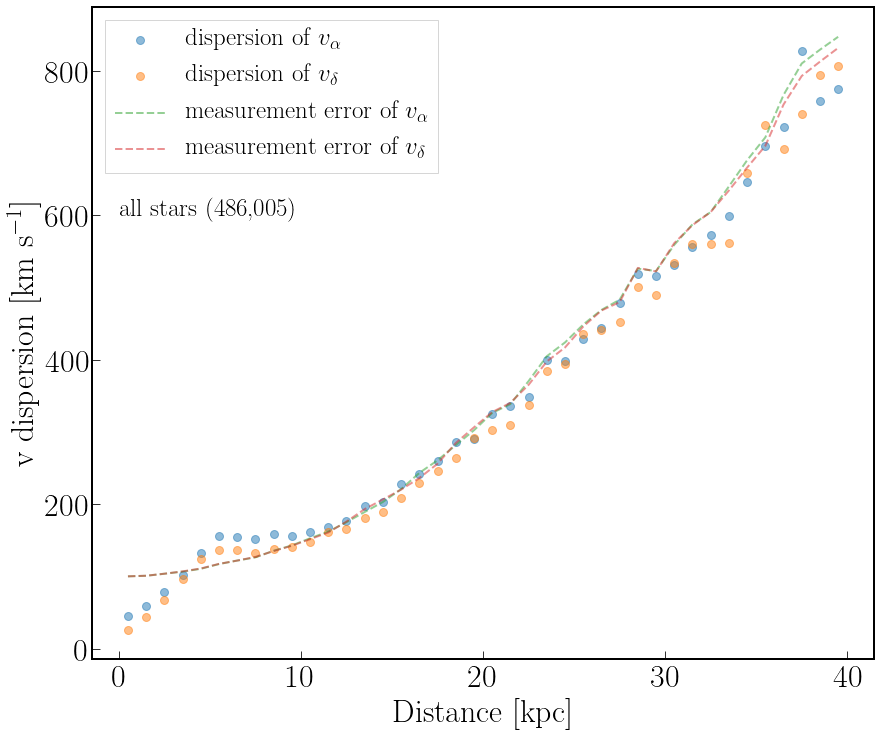

In [280]:
plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.savefig(pwd+'all_v_ra_dec.pdf')

$\sqrt(\frac{1}{N}{\sum_i \sigma_i^2})$

Text(0.5, 0, 'Distance [kpc]')

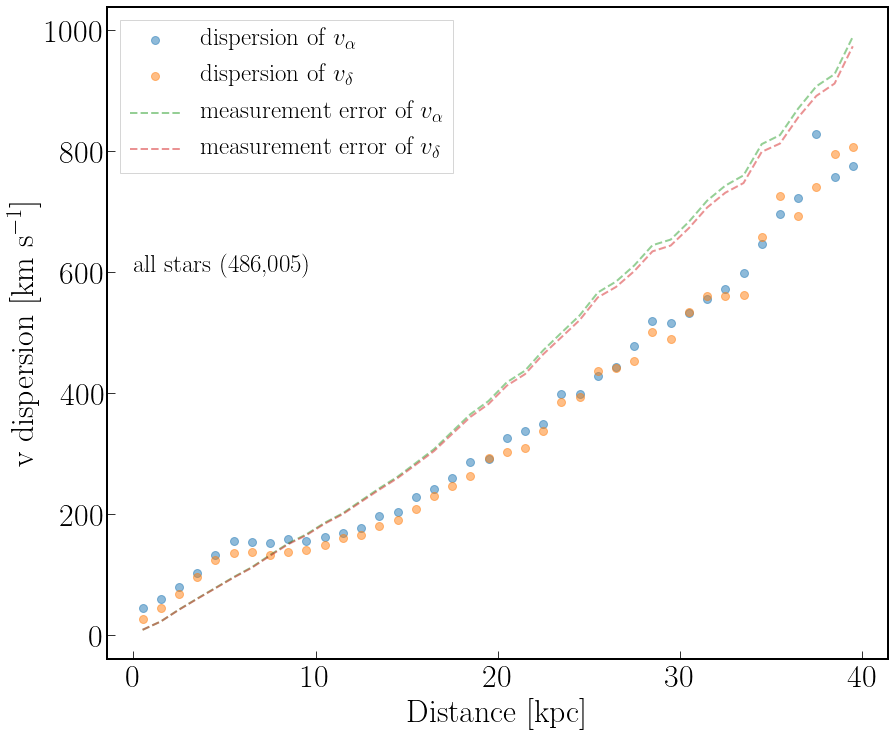

In [268]:
plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
#plt.savefig(pwd+'all_v_ra_dec.pdf')

$\frac{1}{N}(\sum_i \sigma_i)$

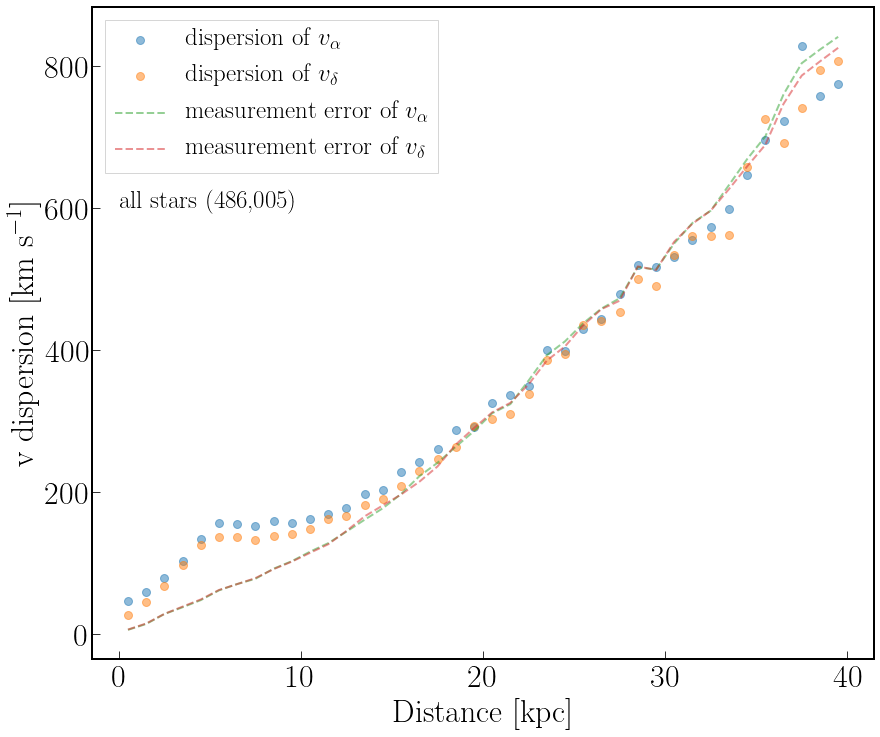

In [243]:
plt.figure(figsize=(14,12))
plt.text(0,600,r'all stars (486,005)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
plt.savefig(pwd+'all_v_ra_dec.pdf')

In [244]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
ta=mb
print(len(ta[ta.Dkpc<40]))
D = ta.Dkpc.values
vra = ta.v_ra_sm.values
vdec = ta.v_dec_sm.values
x1Bin, n1Pts, s1igGbin= fitstd(D, vra, 0, 40, 40, 0)
x.append(x1Bin)
y1.append(s1igGbin)
x1Bin, n1Pts, s1igGbin= fitstd(D, vdec, 0, 40, 40, 0)
x.append(x1Bin)
y2.append(s1igGbin)

vra = ta.vra_dis_err.values
vdec= ta.vdec_dis_err.values
xBin, nPts, medianBin, sigGbin= fitMedians(D, vra, 0, 40, 40, 0)
x.append(xBin)
y3.append(medianBin)
xBin, nPts, medianBin, sigGbin= fitMedians(D, vdec, 0, 40, 40, 0)
x.append(xBin)
y4.append(medianBin)


89038


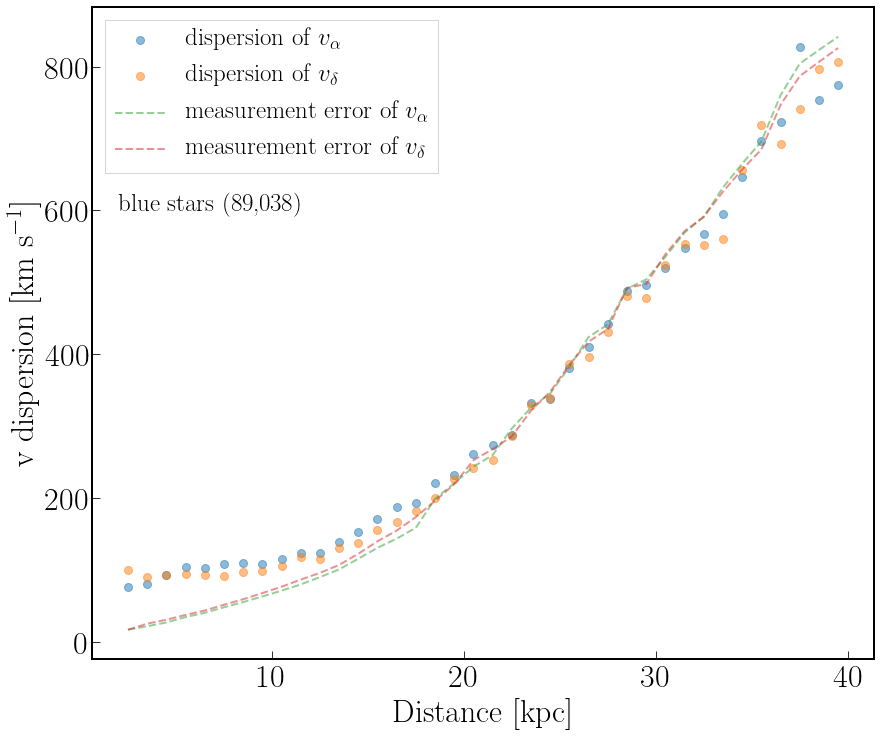

In [245]:
plt.figure(figsize=(14,12))
plt.text(2,600,r'blue stars (89,038)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
plt.savefig(pwd+'blue_v_ra_dec.pdf')

In [65]:
x=[]
y1=[]
y2=[]
y3=[]
y4=[]
ta=mb
print(len(ta[ta.Dkpc<40]))
D = ta.Dkpc.values
vra = ta.v_lcosb_sm.values
vdec = ta.v_b_sm.values
x1Bin, n1Pts, s1igGbin= fitstd(D, vra, 0, 40, 40, 0)
x.append(x1Bin)
y1.append(s1igGbin)
x1Bin, n1Pts, s1igGbin= fitstd(D, vdec, 0, 40, 40, 0)
x.append(x1Bin)
y2.append(s1igGbin)

vra = ta.vl_dis_err.values
vdec= ta.vb_dis_err.values
xBin, nPts, medianBin, sigGbin= fitrms(D, vra, 0, 40, 40, 0)
x.append(xBin)
y3.append(medianBin)
xBin, nPts, medianBin, sigGbin= fitrms(D, vdec, 0, 40, 40, 0)
x.append(xBin)
y4.append(medianBin)


89038


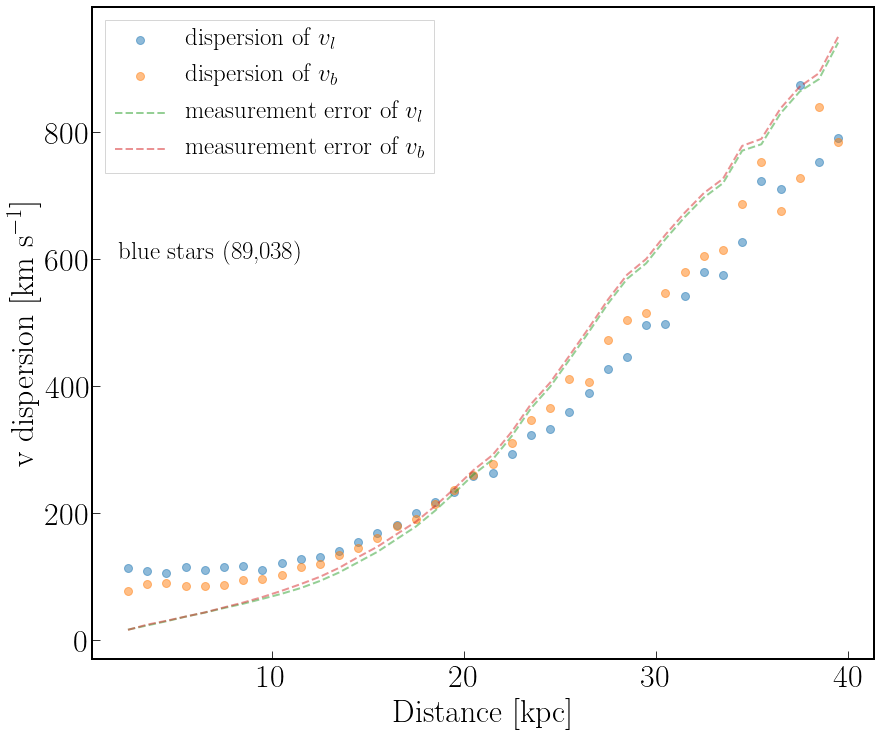

In [69]:
plt.figure(figsize=(14,12))
plt.text(2,600,r'blue stars (89,038)')
plt.errorbar(x[0],y1[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_l$')
plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_b$')
plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_l$')
plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_b$')
plt.legend()
plt.ylabel('v dispersion [km s$^{-1}$]')
plt.xlabel('Distance [kpc]')
plt.savefig(pwd+'blue_v_l_b.pdf')

Text(0.5, 0, '$r_{\\rm PSF}$')

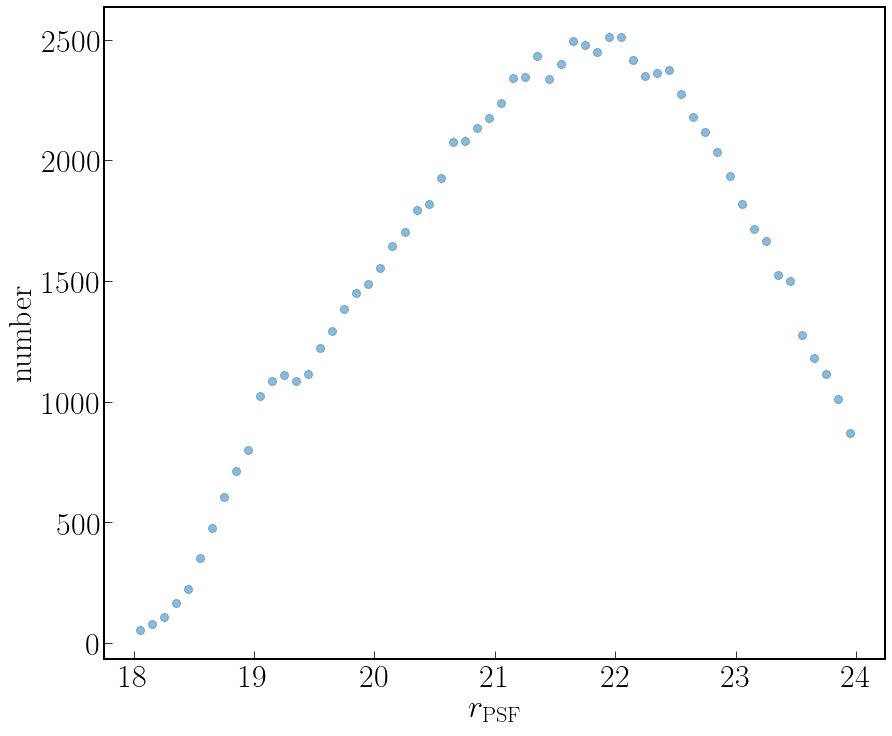

In [82]:
xBin, nPts, medianBin, sigGbin= fitrms(mb.psfMag_r, vra, 18, 24, 60, 0)
plt.figure(figsize=(14,12))
#plt.text(2,600,r'blue stars (89,038)')
plt.errorbar(xBin,nPts,alpha=0.5,fmt='o',capsize=6, markersize=8)
#plt.errorbar(x[0],y2[0],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_b$')
#plt.errorbar(x[0],y3[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_l$')
#plt.errorbar(x[0],y4[0],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_b$')
#plt.legend()
plt.ylabel('number')
plt.xlabel(r'$r_{\rm PSF}$')
#plt.savefig(pwd+'blue_v_l_b.pdf')

## R.A. dependence

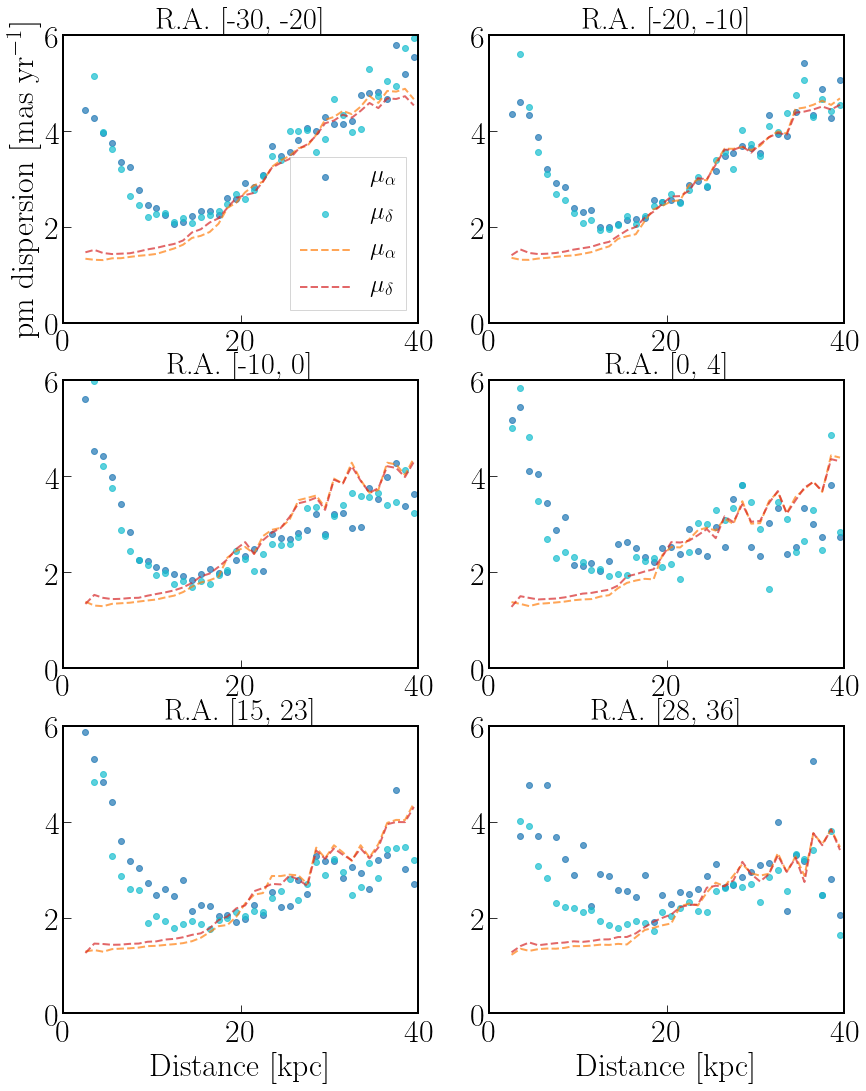

In [251]:
t=mb
ra=[-30,-20,-20,-10,-10,0,0,4,15,23,28,36]
plt.figure(figsize=(14,18))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.title('R.A. ['+str(ra[i*2])+', '+str(ra[i*2+1])+']')
    plt.axis([0,40,0,6])
    ta=t[(t.i_sdsscentroid_ra>ra[i*2])&(t.i_sdsscentroid_ra<ra[i*2+1])]
    D = ta.Dkpc
    vra = ta.pmra_cl_sm
    vdec = ta.pmdec_cl_sm
    x1Bin, n1Pts, s1igGbin = fitstd(D, vra, 0, 40, 40, 0)
    x2Bin, n2Pts, s2igGbin = fitstd(D, vdec, 0, 40, 40, 0)
    #plt.text(5,1500,'Red stars')
    plt.errorbar(x1Bin,s1igGbin,fmt='o',alpha=0.7,color='tab:blue',label=r'$\mu_\alpha$')
    plt.errorbar(x2Bin,s2igGbin,fmt='o',alpha=0.7,color='tab:cyan',label=r'$\mu_\delta$')
    
    
    vra = ta.pmra_dis_err
    vdec = ta.pmdec_dis_err
    x1Bin, n1Pts, m1edianbin, s1igGbin = fitMedians(D, vra, 0, 40, 40, 0)
    x2Bin, n2Pts, m2edianbin, s2igGbin = fitMedians(D, vdec, 0, 40, 40, 0)
    #plt.text(5,1500,'Red stars')
    plt.errorbar(x1Bin,m1edianbin,fmt='--',alpha=0.7,color='tab:orange',label=r'$\mu_\alpha$')
    plt.errorbar(x2Bin,m2edianbin,fmt='--',alpha=0.7,color='tab:red',label=r'$\mu_\delta$')

    #    plt.scatter(x1Bin,std1,label='standard deviation (std)')
    #    plt.scatter(x1Bin,s1igGbin,label=r'$0.741(Q75-Q25)$'+'\n estimated std from percentile')
    if i==0:
        plt.legend()
    if i==0 :
        plt.ylabel('pm dispersion [mas yr$^{-1}$]')
    if i>3:
        plt.xlabel('Distance [kpc]')

plt.savefig(pwd+'pm_blue_R.A..pdf')

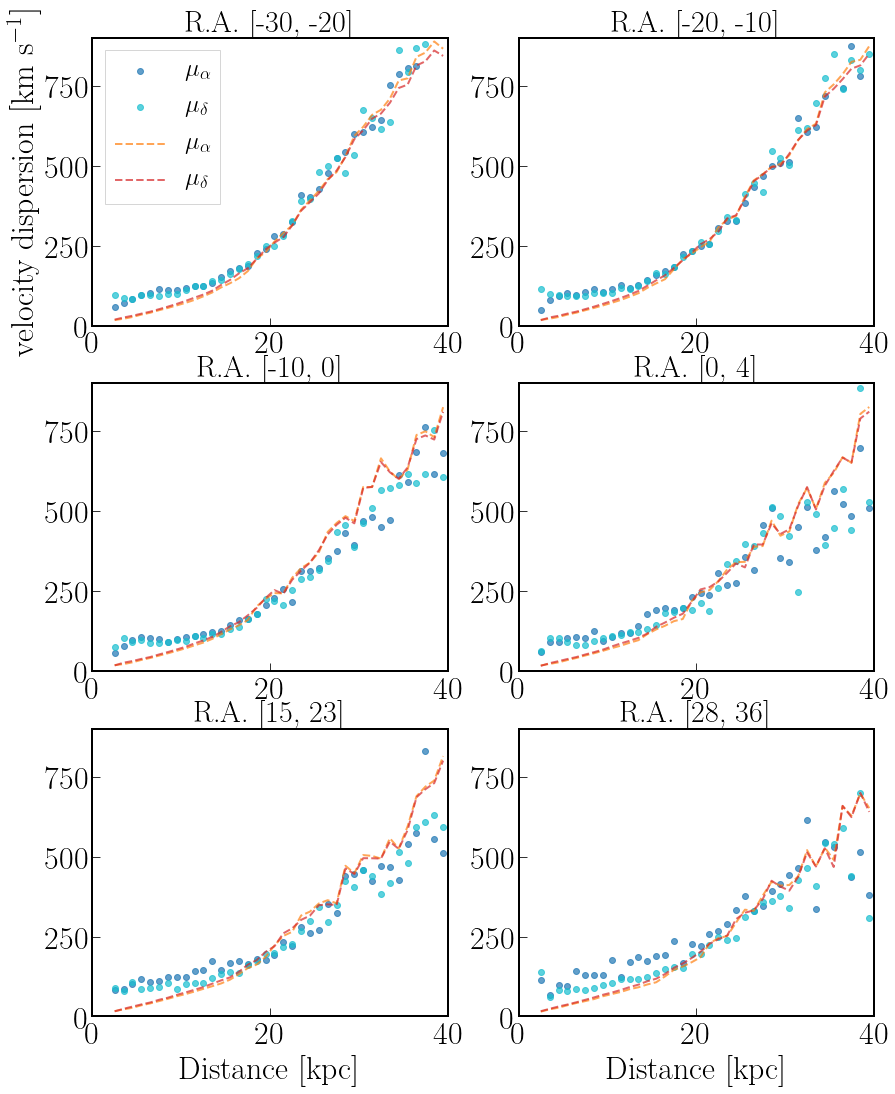

In [255]:
t=mb
ra=[-30,-20,-20,-10,-10,0,0,4,15,23,28,36]
plt.figure(figsize=(14,18))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.title('R.A. ['+str(ra[i*2])+', '+str(ra[i*2+1])+']')
    plt.axis([0,40,0,900])
    ta=t[(t.i_sdsscentroid_ra>ra[i*2])&(t.i_sdsscentroid_ra<ra[i*2+1])]
    D = ta.Dkpc
    vra = ta.v_ra_sm
    vdec = ta.v_dec_sm
    x1Bin, n1Pts, s1igGbin = fitstd(D, vra, 0, 40, 40, 0)
    x2Bin, n2Pts, s2igGbin = fitstd(D, vdec, 0, 40, 40, 0)
    #plt.text(5,1500,'Red stars')
    plt.errorbar(x1Bin,s1igGbin,fmt='o',alpha=0.7,color='tab:blue',label=r'$\mu_\alpha$')
    plt.errorbar(x2Bin,s2igGbin,fmt='o',alpha=0.7,color='tab:cyan',label=r'$\mu_\delta$')
    
    
    vra = ta.vra_dis_err
    vdec = ta.vdec_dis_err
    x1Bin, n1Pts, m1edianbin, s1igGbin = fitMedians(D, vra, 0, 40, 40, 0)
    x2Bin, n2Pts, m2edianbin, s2igGbin = fitMedians(D, vdec, 0, 40, 40, 0)
    #plt.text(5,1500,'Red stars')
    plt.errorbar(x1Bin,m1edianbin,fmt='--',alpha=0.7,color='tab:orange',label=r'$\mu_\alpha$')
    plt.errorbar(x2Bin,m2edianbin,fmt='--',alpha=0.7,color='tab:red',label=r'$\mu_\delta$')

    #    plt.scatter(x1Bin,std1,label='standard deviation (std)')
    #    plt.scatter(x1Bin,s1igGbin,label=r'$0.741(Q75-Q25)$'+'\n estimated std from percentile')
    if i==0:
        plt.legend()
    if i==0 :
        plt.ylabel('velocity dispersion [km s$^{-1}$]')
    if i>3:
        plt.xlabel('Distance [kpc]')

plt.savefig(pwd+'v_blue_R.A..pdf')

## narrow magnitude bin

In [385]:
x=[]
n=[]
y1=[]
y2=[]
std1=[]
std2=[]
y3=[]
y4=[]
y5=[]
y6=[]
sig1=[]
sig2=[]
for i in range(4):
    ta=mb[(mb.psfMag_r<20.5+i)&(mb.psfMag_r>18.5+i)]#&(mb.i_sdsscentroid_ra<0)]
    n.append(len(ta[ta.Dkpc<30]))
    D = ta.Dkpc.values
    vra = ta.v_ra_sm.values
    vdec = ta.v_dec_sm.values
    x1Bin, n1Pts, s1igGbin,std= vd(D, vra, 0, 30, 30, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    std1.append(std)
    x1Bin, n1Pts, s1igGbin,std= vd(D, vdec, 0, 30, 30, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    std2.append(std)
    
    vra = ta.vra_dis_err.values
    vdec= ta.vdec_dis_err.values
    xBin, nPts, medianBin,sigGbin= fitrms(D, vra, 0, 30, 30, 0)
    x.append(xBin)
    y3.append(medianBin)
    sig1.append(sigGbin)
    y5.append(np.sqrt(medianBin**2+6400))
    xBin, nPts, medianBin,sigGBin= fitrms(D, vdec, 0, 30, 30, 0)
    x.append(xBin)
    y4.append(medianBin)
    sig2.append(sigGbin)
    y6.append(np.sqrt(medianBin**2+6400))


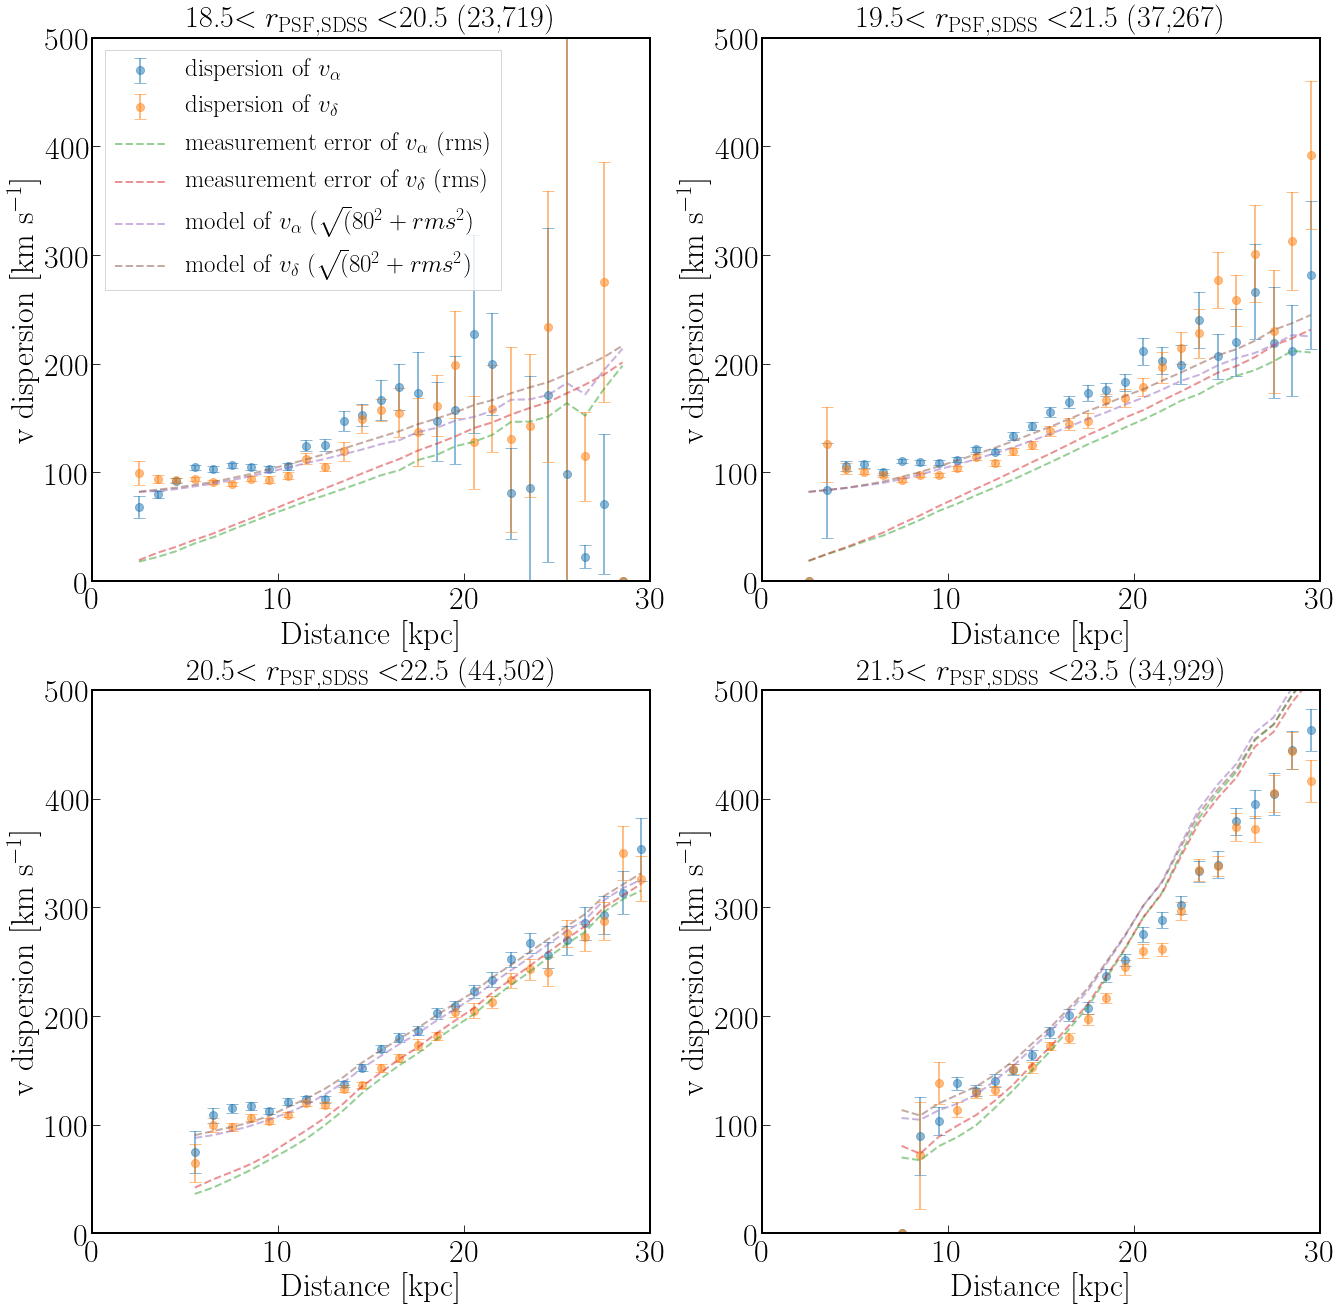

In [387]:

plt.figure(figsize=(22,22))
#plt.text(0,600,r'all stars (486,005)')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(str(18.5+i)+r'$<r_{\rm PSF,SDSS}<$'+str(20.5+i)+' ('+format(n[i],',')+')')
    plt.errorbar(x[i],y1[i],std1[i],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\alpha$')
    plt.errorbar(x[i],y2[i],std2[i],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_\delta$')
    plt.errorbar(x[i],y3[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$ (rms)')
    plt.errorbar(x[i],y4[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$ (rms)')    
    plt.errorbar(x[i],y5[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'model of $v_\alpha$ ($\sqrt(80^2+rms^2$)')
    plt.errorbar(x[i],y6[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'model of $v_\delta$ ($\sqrt(80^2+rms^2$)')
    plt.axis([0,30,0,500])
    plt.ylabel('v dispersion [km s$^{-1}$]')
    plt.xlabel('Distance [kpc]')
    if i==0:
        plt.legend()
plt.savefig(pwd+'blue_v_ra_dec_model.pdf')

In [61]:
x=[]
n=[]
y1=[]
y2=[]
std1=[]
std2=[]
y3=[]
y4=[]
y5=[]
y6=[]
sig1=[]
sig2=[]
for i in range(4):
    ta=mb[(mb.psfMag_r<20.5+i)&(mb.psfMag_r>18.5+i)]#&(mb.i_sdsscentroid_ra<0)]
    n.append(len(ta[ta.Dkpc<30]))
    D = ta.Dkpc.values
    vra = ta.v_lcosb_sm.values
    vdec = ta.v_b_sm.values
    x1Bin, n1Pts, s1igGbin,std= vd(D, vra, 0, 30, 30, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    std1.append(std)
    x1Bin, n1Pts, s1igGbin,std= vd(D, vdec, 0, 30, 30, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    std2.append(std)
    
    vra = ta.vl_dis_err.values
    vdec= ta.vb_dis_err.values
    xBin, nPts, medianBin,sigGbin= fitrms(D, vra, 0, 30, 30, 0)
    x.append(xBin)
    y3.append(medianBin)
    sig1.append(sigGbin)
    y5.append(np.sqrt(medianBin**2+6400))
    xBin, nPts, medianBin,sigGBin= fitrms(D, vdec, 0, 30, 30, 0)
    x.append(xBin)
    y4.append(medianBin)
    sig2.append(sigGbin)
    y6.append(np.sqrt(medianBin**2+6400))


/Users/tianqiu/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


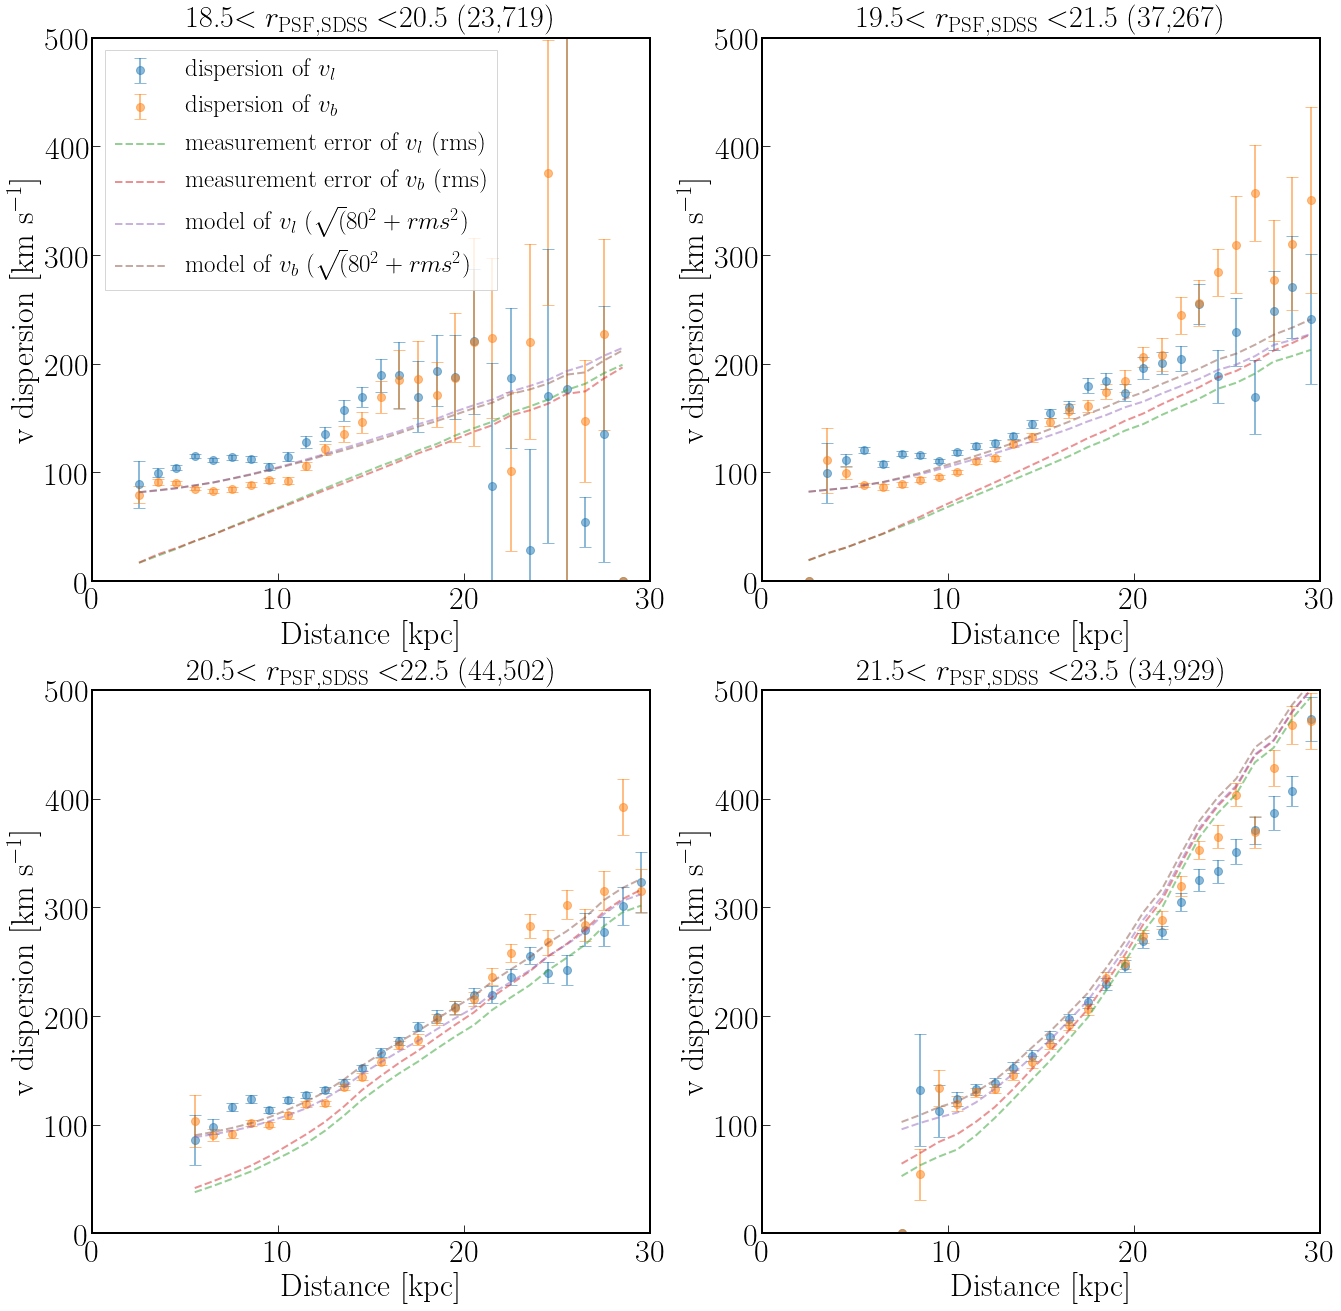

In [62]:

plt.figure(figsize=(22,22))
#plt.text(0,600,r'all stars (486,005)')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(str(18.5+i)+r'$<r_{\rm PSF,SDSS}<$'+str(20.5+i)+' ('+format(n[i],',')+')')
    plt.errorbar(x[i],y1[i],std1[i],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_l$')
    plt.errorbar(x[i],y2[i],std2[i],alpha=0.5,fmt='o',capsize=6, markersize=8,label=r'dispersion of $v_b$')
    plt.errorbar(x[i],y3[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_l$ (rms)')
    plt.errorbar(x[i],y4[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_b$ (rms)')    
    plt.errorbar(x[i],y5[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'model of $v_l$ ($\sqrt(80^2+rms^2$)')
    plt.errorbar(x[i],y6[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'model of $v_b$ ($\sqrt(80^2+rms^2$)')
    plt.axis([0,30,0,500])
    plt.ylabel('v dispersion [km s$^{-1}$]')
    plt.xlabel('Distance [kpc]')
    if i==0:
        plt.legend()
plt.savefig(pwd+'blue_v_l_b_model.pdf')

# galactic coordinate error

In [531]:
ra=mb.i_sdsscentroid_ra
dec=mb.i_sdsscentroid_dec
dra=mb.pmra_dis_err/10000
ddec=mb.pmdec_dis_err/10000
ra2=ra+dra
dec2=dec+ddec
t1=SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
t2=SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, frame='icrs')

In [547]:
ra=50
dec=0
dra=0.001
ddec=0.001
ra2=ra+dra
dec2=dec+ddec
t1=SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
t2=SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, frame='icrs')

In [532]:
mb['pml_cosb_err']=abs(t2.galactic.l.value-t1.galactic.l.value)*10000*np.cos(t1.galactic.b.value*np.pi/180)

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [533]:
mb['pmb_err']=abs(t2.galactic.b.value-t1.galactic.b.value)*10000

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [439]:
ra0=mb.iloc[1].i_sdsscentroid_ra
dec0=mb.iloc[1].i_sdsscentroid_dec
dra0=mb.iloc[1].pmra_dis_err
ddec0=mb.iloc[1].pmdec_dis_err
D0=mb.iloc[1].Dkpc

In [552]:
mb

,# object_id,i_extendedness_value,ra_1,dec_1,r_extendedness_value,i_sdsscentroid_ra,i_sdsscentroid_dec,i_sdsscentroid_rasigma,i_sdsscentroid_decsigma,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,g_psfflux_mag,r_psfflux_mag,i_psfflux_mag,z_psfflux_mag,g_psfflux_magsigma,r_psfflux_magsigma,i_psfflux_magsigma,z_psfflux_magsigma,a_g,a_r,a_i,a_z,mean_mjd,objID,ra_2,dec_2,type,rowc_r,colc_r,rowcErr_r,colcErr_r,u,g,r,i,z,err_u,err_g,err_r,err_i,err_z,psfmag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,S82_mean_mjd,Separation,delta_mjd,delta_yr,ra_s_error,dec_s_error,dra,ddec,dra_err,ddec_err,pmra,pmdec,pmra_err,pmdec_err,pmra_cl,pmdec_cl,ug,gr,FeH,Dkpc,ri,iz,gi,gc,rc,ic,pmdec_cl2,pmra_cl2,pmra_cl3,pmdec_cl3,pmra_cl_sm,pmdec_cl_sm,l,b,pm_lcosb,pm_b,pm_lcosb_sm,pm_b_sm,galcen_x,galcen_y,galcen_z,galcen_vx,galcen_vy,galcen_vz,v_ra,v_dec,v_b,v_lcosb,v_ra_sm,v_dec_sm,v_b_sm,v_lcosb_sm,pmra_dis_err,pmdec_dis_err,vra_dis_err,vdec_dis_err,pml_cosb_err,pmb_err,vl_err,vb_err
3266,41653902801654228,0.0,3.656700,0.230900,NaN,3.656700,0.230900,0.000263,0.000372,18.236126,NaN,17.938999,17.885237,0.000656,NaN,0.000770,0.001158,18.232193,18.040608,17.936640,17.899420,0.000639,0.000446,0.000761,0.001142,0.089393,0.062796,0.045055,0.034847,58014.509900,8647475121443438640,3.656689,0.230925,3,336.1301,262.77690,0.001661,0.001611,19.20335,18.29679,18.05156,17.94824,17.91554,0.006952,0.003581,0.004040,0.004417,0.006519,19.19016,18.27332,18.00569,17.90570,17.89901,0.006269,0.004190,0.004617,0.004969,0.007961,0.142238,0.104657,0.075906,0.057557,0.040809,53144.235706,0.098709,4870.274194,13.334449,0.000658,0.000638,38.532426,-90.877260,0.708040,0.738421,2.889690,-6.815224,0.053099,0.055377,1.306521,-9.589966,0.939907,0.201595,-1.505736,5.894978,0.125026,0.037220,0.326620,18.250253,18.048659,17.923633,-9.051966,1.256521,1.149577,-9.041756,-3.183371,-2.922275,103.514444,-61.245368,-1.577151,-8.977053,-3.905474,-1.849543,-8.979462,2.757323,-5.138870,104.955301,28.700272,-113.736410,32.147136,-252.846545,-251.037160,-44.103946,-89.020789,-81.719424,-51.721210,-109.213926,0.527761,0.967362,14.758465,27.051611,0.790345,0.767898,22.101473,21.473754
3714,40638246115368032,0.0,21.070518,-0.505444,0.0,21.070519,-0.505444,0.000341,0.000392,18.328604,18.085249,18.020298,17.988514,0.000516,0.000457,0.000917,0.001256,18.330139,18.088215,18.019165,17.990151,0.000508,0.000453,0.000912,0.001175,0.098504,0.069196,0.049647,0.038398,58014.540674,8647475120377299096,21.070452,-0.505406,6,767.0599,1197.03800,0.001670,0.001783,19.23633,18.32481,18.08425,17.99016,17.98760,0.006422,0.003336,0.003798,0.004121,0.005567,19.23425,18.34125,18.08688,17.99361,17.98386,0.005114,0.001117,0.001042,0.001148,0.003569,0.156750,0.115335,0.083651,0.063430,0.044973,53145.818606,0.279536,4868.722068,13.330200,0.000661,0.000706,242.636709,-138.824656,0.743882,0.807811,18.202031,-10.414297,0.055804,0.060600,14.191679,-9.788139,0.885325,0.251820,-1.534880,5.626958,0.092543,0.029014,0.344363,18.348925,18.097105,18.004562,-9.250139,14.141679,14.016435,-9.195164,8.559462,-2.749566,140.783549,-62.233408,15.993448,-5.022063,8.984903,-0.309890,-10.347125,1.657416,-4.945397,-166.994259,-173.230380,-54.580200,374.139284,-245.445569,-134.053427,426.911478,228.476858,-73.393875,-8.271849,239.833093,0.801661,1.131109,21.398652,30.192583,0.462603,1.306911,12.348206,34.885239
4575,41566362778228492,0.0,-26.561182,-0.984551,0.0,-26.561183,-0.984551,0.000245,0.000248,18.331640,18.106739,18.024597,18.019974,0.000597,0.000709,0.000602,0.000899,18.336090,18.104763,18.021946,18.016239,0.000595,0.000687,0.000598,0.000887,0.333166,0.234039,0.167920,0.129873,56984.207235,8647475119819587700,-26.561188,-0.984560,6,550.1583,655.09080,0.001864,0.001947,19.35873,18.32511,18.08745,18.00935,17.98616,0.007221,0.003623,0.004001,0.004255,

In [553]:
vra0=mb.iloc[1].v_ra_sm
vdec0=mb.iloc[1].v_dec_sm
vl0=mb.iloc[1].v_lcosb_sm
vb0=mb.iloc[1].v_b_sm

In [608]:
def b(a,d):
    sinb=np.sin(27.13*np.pi/180)*np.sin(d*np.pi/180)+np.cos(27.13*np.pi/180)*np.cos(d*np.pi/180)*np.cos((a-192.85)*np.pi/180)
    return np.arcsin(sinb)*180/np.pi

In [601]:
def l(a,d,b):
    sinl=1/np.cos(b*np.pi/180)*(np.cos(d*np.pi/180)*np.sin((a-192.85)*np.pi/180))
    return sinl

In [576]:
np.arcsin(b(ra0,dec0))/np.pi*180

-65.27604597131409

In [609]:
b(ra0,dec0)

-65.27604597131409

In [610]:
(l(ra0,dec0,b(ra0,dec0)))

0.1786693879579309

In [597]:
a=SkyCoord(ra=90*u.degree, dec=90*u.degree, pm_ra_cosdec=0.01*u.mas/u.year, pm_dec=0.01*u.mas/u.year, radial_velocity=0*u.km/u.s, frame='icrs')

In [598]:
a

<SkyCoord (ICRS): (ra, dec) in deg
    (90., 90.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.01, 0.01, 0.)>

In [599]:
a.galactic

<SkyCoord (Galactic): (l, b) in deg
    (122.93192526, 27.12825241)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.00752358, 0.0119748, 0.)>

In [534]:
mb['vl_err']=mb.pml_cosb_err*mb.Dkpc/3600*3.261564*300000*np.pi/180
mb['vb_err']=mb.pmb_err*mb.Dkpc/3600*3.261564*300000*np.pi/180

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(array([   0.,  317., 2302., 5976., 5842., 5064., 4664., 4360., 3855.,
        3492., 3372., 3128., 2792., 2515., 2307., 2090., 1848., 1726.,
        1666., 1629., 1518., 1414., 1225., 1231., 1148., 1076., 1069.,
         940.,  918.,  838.,  819.,  734.,  676.,  685.,  623.,  553.,
         602.,  530.,  545.,  512.,  453.,  486.,  462.,  444.,  399.,
         360.,  331.,  316.,  349.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 1 Patch objects>)

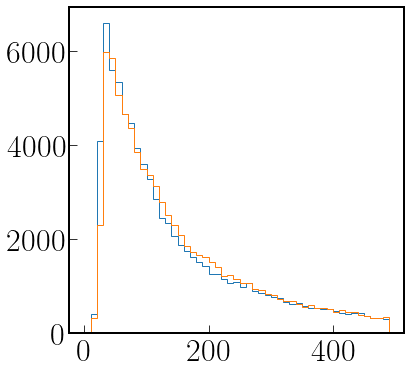

In [514]:
plt.hist(mb.vra_dis_err,histtype='step',bins=np.arange(0,500,10))
plt.hist(mb.vdec_dis_err,histtype='step',bins=np.arange(0,500,10))

[0, 100, 0, 100]

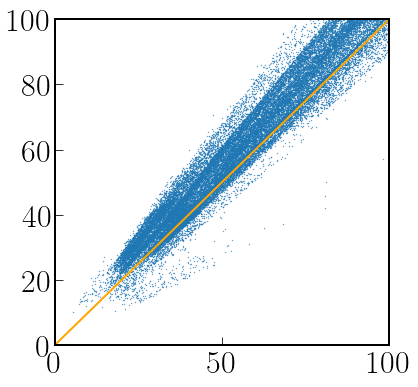

In [56]:
plt.scatter(mb.vra_dis_err,mb.vdec_dis_err,s=0.1)
plt.plot(range(5000),range(5000),color='orange')
plt.axis([0,100,0,100])

[0, 100, 0, 100]

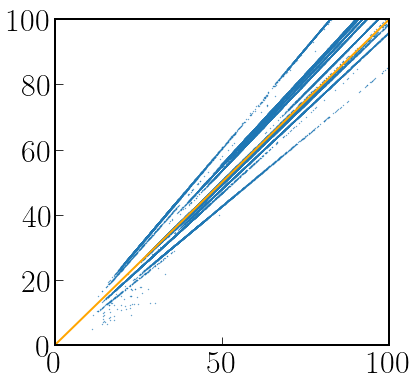

In [58]:
plt.scatter(mb.vl_dis_err,mb.vb_dis_err,s=0.1)
plt.plot(range(5000),range(5000),color='orange')
plt.axis([0,100,0,100])

(array([ 437., 1059., 1516., 3116., 4436., 5436., 4082., 4131., 3875.,
        3547., 3358., 3094., 2748., 2638., 2491., 2296., 2026., 1795.,
        1627., 1649., 1417., 1356., 1197., 1203., 1038., 1066.,  995.,
         986.,  893.,  842.,  813.,  774.,  690.,  693.,  696.,  682.,
         609.,  617.,  543.,  536.,  515.,  483.,  454.,  432.,  419.,
         403.,  390.,  374.,  355.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 1 Patch objects>)

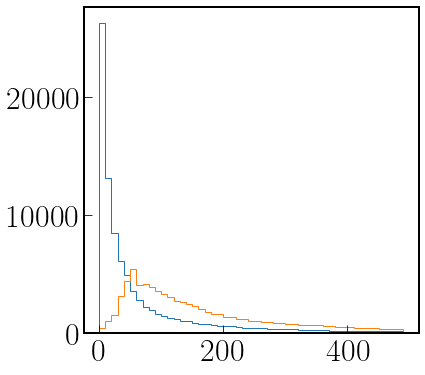

In [521]:
plt.hist(mb.vb_err,histtype='step',bins=np.arange(0,500,10))
plt.hist(mb.vl_err,histtype='step',bins=np.arange(0,500,10))

## new

In [612]:
def cos(x):
    return np.cos(x*np.pi/180)
def sin(x):
    return np.sin(x*np.pi/180)

In [653]:
def dl(l,b,a,d,da,dd):
    t=(sin(d)*sin(a-192.85)/cos(b)/cos(122.932-l))**2*dd**2+(cos(d)*cos(a-192.85)/cos(b)/cos(122.932-l))**2*da**2
    #t=(cos(27.13)*cos(d)+sin(27.13)*sin(d)*cos(a-192.85))**2/(cos(b)*sin(122.832-l))**2*dd**2+(sin(27.13)*cos(d)*cos(a-192.85))**2/(cos(b)*sin(122.832-l))**2*da**2
    #t=(cos(27.13)/cos(d)**2/sin(a-192.85)*sin(122.932-l)**2)**2*dd**2+sin(122.932-l)**4*(sin(27.13)/sin(a-192.85)**2-cos(27.13)*sin(d)/cos(d)*cos(a-192.85)/sin(a-192.85)**2)**2*da**2
    return np.sqrt(t)
def db(b,a,d,da,dd):
    t=(cos(27.13)*cos(d)/cos(b)*sin(a-192.85))**2*da**2+(
        sin(27.13)*cos(d)-cos(27.13)*sin(d)*cos(a-192.85))**2/cos(b)**2*dd**2
    return np.sqrt(t)


In [647]:
ra0=mb.iloc[1000].i_sdsscentroid_ra
dec0=mb.iloc[1000].i_sdsscentroid_dec
dra0=mb.iloc[1000].pmra_dis_err
ddec0=mb.iloc[1000].pmdec_dis_err
l0=mb.iloc[1000].l
b0=mb.iloc[1000].b

In [654]:
db(b0,ra0,dec0,dra0,ddec0),dl(l0,b0,ra0,dec0,dra0,ddec0)

(1.2294643996191723, 3.189711685807526)

In [649]:
db(b0,ra0,dec0,dra0,ddec0),dl(l0,ra0,dec0,dra0,ddec0)

(1.2294643996191723, 2.5179043922363924)

In [650]:
dra0,ddec0

(1.4193050950776365, 1.1388763575307568)

# final result

In [48]:
fl=mb[(mb.psfMag_r>20.5)&(mb.psfMag_r<22.5)]

In [476]:
x=[]
n=[]
y1=[]
y2=[]
std1=[]
std2=[]
y3=[]
y4=[]
y5=[]
y6=[]
sig1=[]
sig2=[]
ra=[-30,-20,-20,-10,-10,0,0,4,15,23,28,36]
for i in range(6):
    ta=fl[(fl.i_sdsscentroid_ra>ra[i*2])&(fl.i_sdsscentroid_ra<ra[i*2+1])]
    n.append(len(ta[ta.Dkpc<30]))
    D = ta.Dkpc.values
    vra = ta.v_ra_sm.values
    vdec = ta.v_dec_sm.values
    x1Bin, n1Pts, s1igGbin,std= vd(D, vra, 0, 30, 30, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    std1.append(std)
    x1Bin, n1Pts, s1igGbin,std= vd(D, vdec, 0, 30, 30, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    std2.append(std)
    
    vra = ta.vra_dis_err.values
    vdec= ta.vdec_dis_err.values
    xBin, nPts, medianBin,sigGbin= fitrms(D, vra, 0, 30, 30, 0)
    x.append(xBin)
    y3.append(medianBin)
    sig1.append(sigGbin)
    y5.append(np.sqrt(medianBin**2+6400))
    xBin, nPts, medianBin,sigGBin= fitrms(D, vdec, 0, 30, 30, 0)
    x.append(xBin)
    y4.append(medianBin)
    sig2.append(sigGbin)
    y6.append(np.sqrt(medianBin**2+6400))



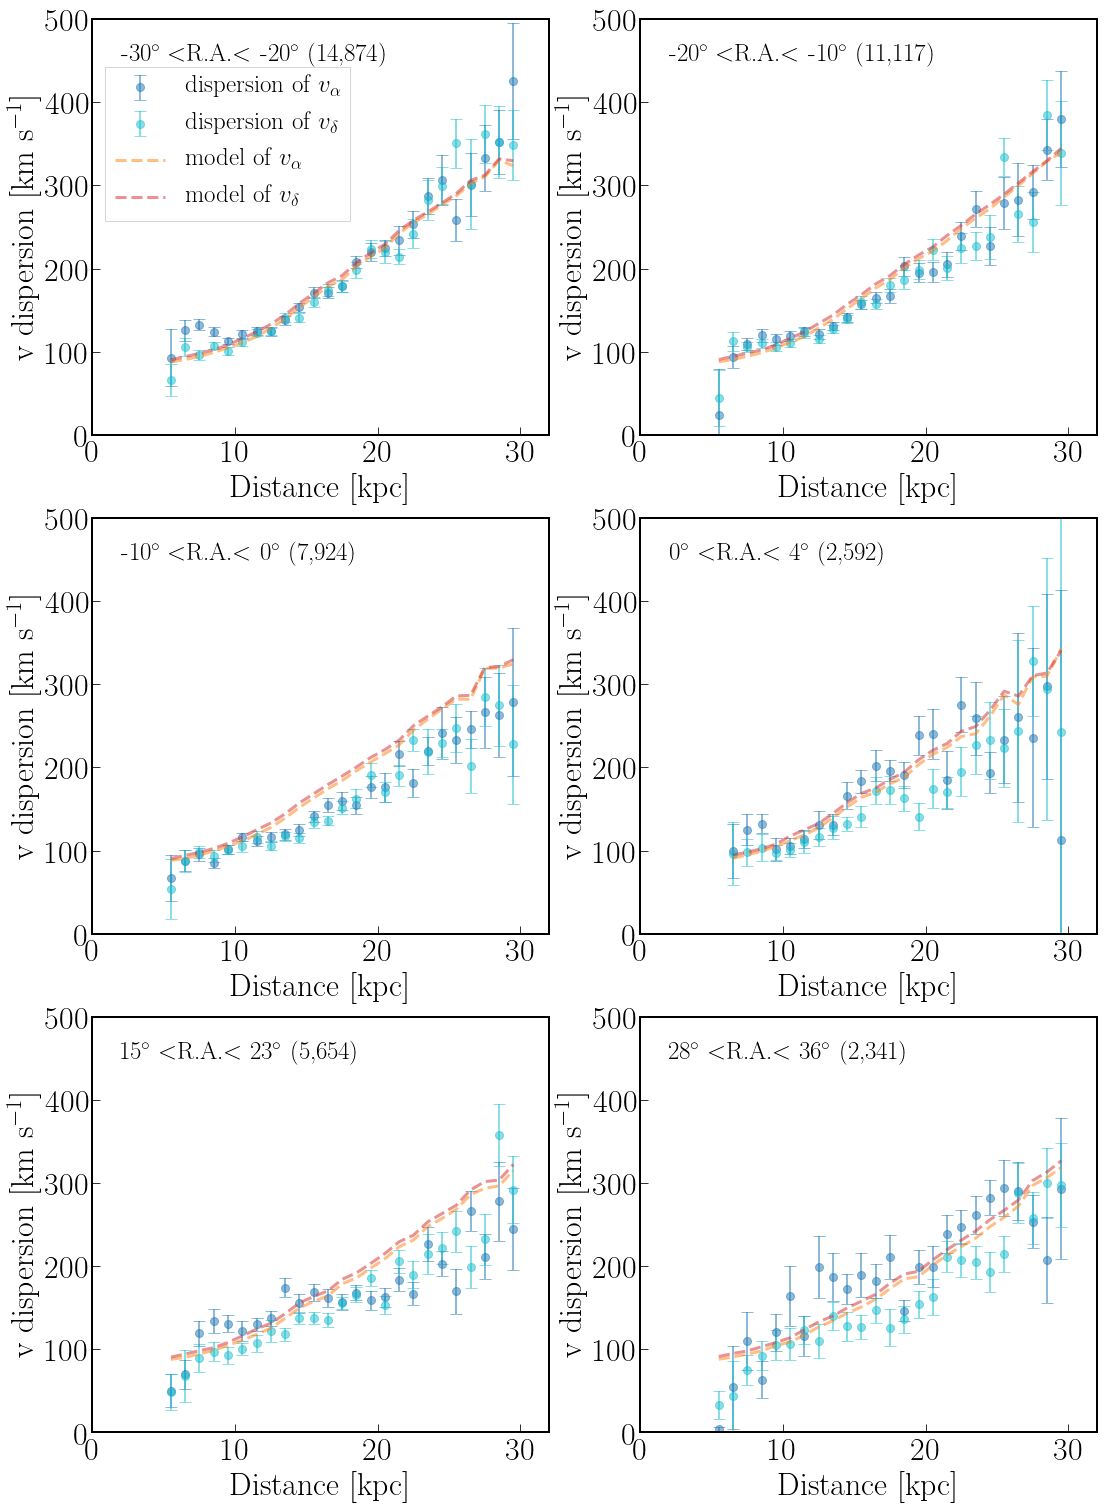

In [477]:

plt.figure(figsize=(18,26))
#plt.text(0,600,r'all stars (486,005)')
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.text(2,450,str(ra[i*2])+'$^\circ<$R.A.$<$ '+str(ra[i*2+1])+'$^\circ$ ('+format(n[i],',')+')')
    #plt.title(str(18.5+i)+r'$<r_{\rm PSF,SDSS}<$'+str(20.5+i)+' ('+format(n[i],',')+')')
    plt.errorbar(x[i],y1[i],std1[i],alpha=0.5,fmt='o',capsize=6,color='tab:blue', markersize=8,label=r'dispersion of $v_\alpha$')
    plt.errorbar(x[i],y2[i],std2[i],alpha=0.5,fmt='o',capsize=6,color='tab:cyan', markersize=8,label=r'dispersion of $v_\delta$')
    #plt.errorbar(x[i],y3[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$ (rms)')
    #plt.errorbar(x[i],y4[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$ (rms)')    
    plt.errorbar(x[i],y5[i],alpha=0.5,fmt='--',linewidth=3,capsize=6, color='tab:orange',markersize=8,label=r'model of $v_\alpha$')
    plt.errorbar(x[i],y6[i],alpha=0.5,fmt='--',linewidth=3,capsize=6, color='tab:red',markersize=8,label=r'model of $v_\delta$')
    plt.axis([0,32,0,500])
    plt.ylabel('v dispersion [km s$^{-1}$]')
    plt.xlabel('Distance [kpc]')
    if i==0:
        plt.legend(loc=6,bbox_to_anchor=(0, 0.7))
plt.savefig(pwd+'blue_v_ra_dec_model_ra.pdf')

In [90]:
x=[]
n=[]
y1=[]
y2=[]
std1=[]
std2=[]
y3=[]
y4=[]
y5=[]
y6=[]
sig1=[]
sig2=[]
ra=[-30,-20,-20,-10,-10,0,0,4,15,23,28,36]
for i in range(6):
    ta=fl[(fl.i_sdsscentroid_ra>ra[i*2])&(fl.i_sdsscentroid_ra<ra[i*2+1])]
    n.append(len(ta[ta.Dkpc<30]))
    D = ta.Dkpc.values
    vl = ta.v_lcosb_sm.values
    vb = ta.v_b_sm.values
    x1Bin, n1Pts, s1igGbin,std= vd(D, vl, 0, 30, 30, 0)
    x.append(x1Bin)
    y1.append(s1igGbin)
    std1.append(std)
    x1Bin, n1Pts, s1igGbin,std= vd(D, vb, 0, 30, 30, 0)
    x.append(x1Bin)
    y2.append(s1igGbin)
    std2.append(std)
    
    vl = ta.vl_dis_err.values
    vb= ta.vb_dis_err.values
    xBin, nPts, medianBin,sigGbin= fitrms(D, vl, 0, 30, 30, 0)
    x.append(xBin)
    y3.append(medianBin)
    sig1.append(sigGbin)
    y5.append(np.sqrt(medianBin**2+6400))
    xBin, nPts, medianBin,sigGBin= fitrms(D, vb, 0, 30, 30, 0)
    x.append(xBin)
    y4.append(medianBin)
    sig2.append(sigGbin)
    y6.append(np.sqrt(medianBin**2+6400))




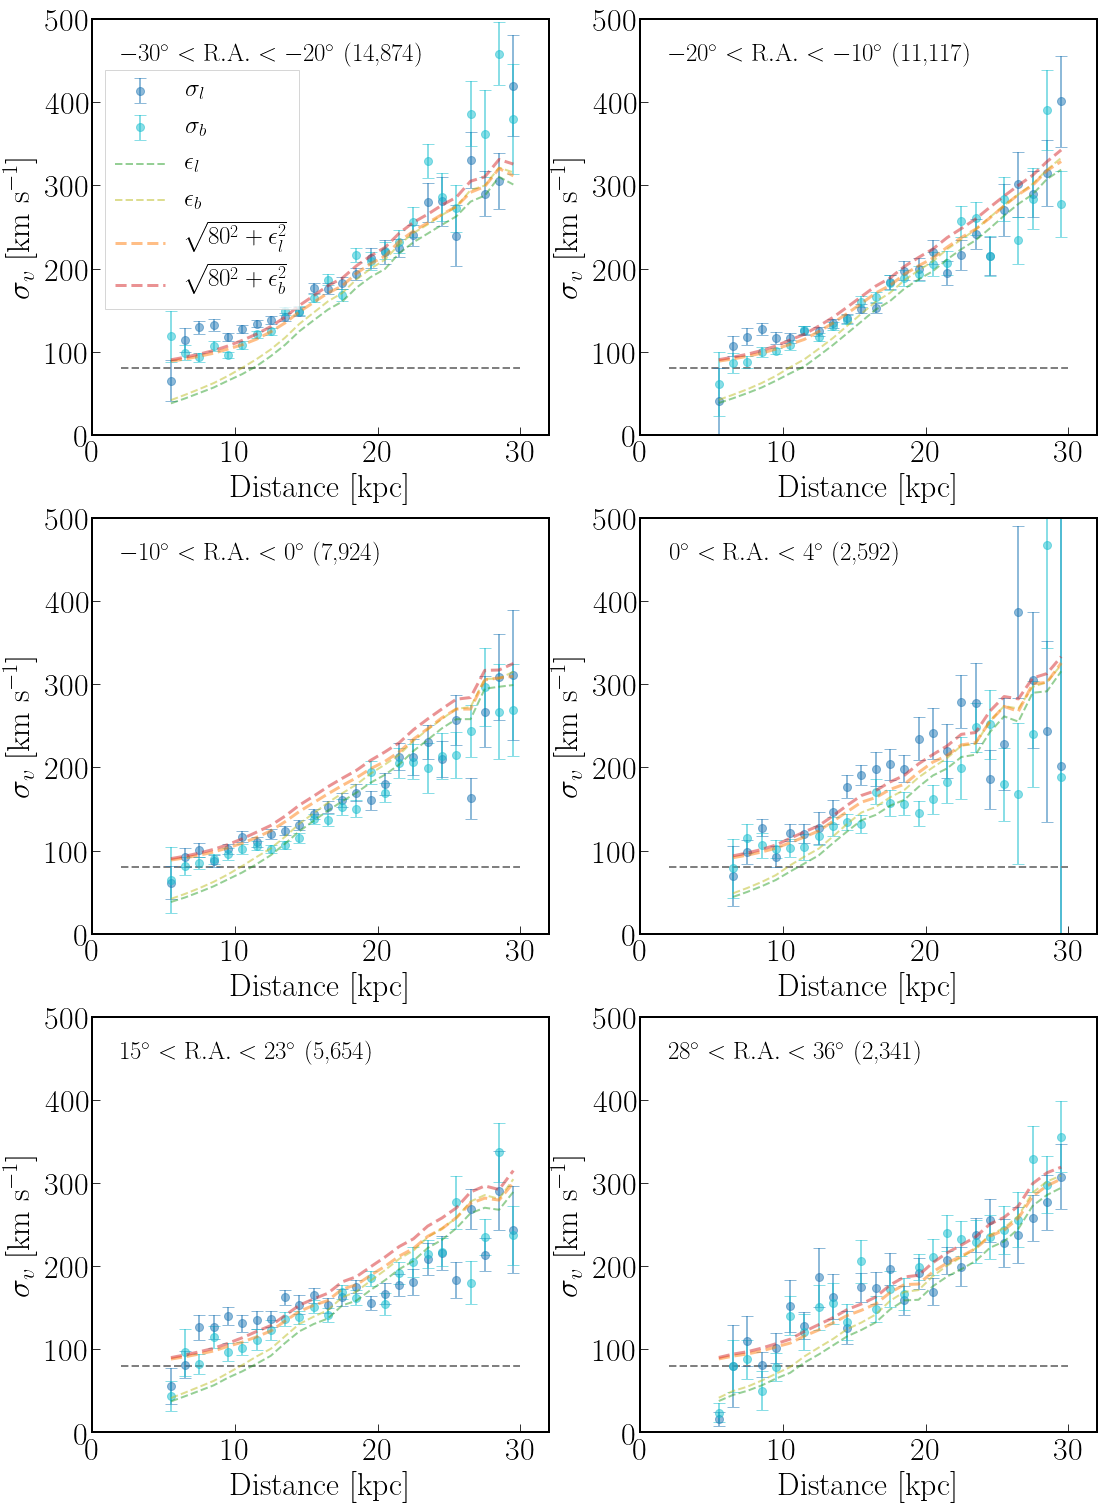

In [114]:

plt.figure(figsize=(18,26))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.text(2,450,fr'${ra[i*2]}^\circ<\rm R.A.<{ra[i*2+1]}^\circ$ ('+format(n[i],',')+')')
    #plt.title(str(18.5+i)+r'$<r_{\rm PSF,SDSS}<$'+str(20.5+i)+' ('+format(n[i],',')+')')
    plt.errorbar(x[i],y1[i],std1[i],alpha=0.5,fmt='o',capsize=6,color='tab:blue', markersize=8,label=r'$\sigma_l$')
    plt.errorbar(x[i],y2[i],std2[i],alpha=0.5,fmt='o',capsize=6,color='tab:cyan', markersize=8,label=r'$\sigma_b$')
    #plt.errorbar(x[i],y3[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\alpha$ (rms)')
    #plt.errorbar(x[i],y4[i],alpha=0.5,fmt='--',capsize=6, markersize=8,label=r'measurement error of $v_\delta$ (rms)') 
    
    plt.errorbar(x[i],y3[i],alpha=0.5,fmt='--',capsize=6, color='tab:green',markersize=8,label=r'$\epsilon_l$')
    plt.errorbar(x[i],y4[i],alpha=0.5,fmt='--',capsize=6, color='tab:olive',markersize=8,label=r'$\epsilon_b$')
    plt.errorbar(x[i],y5[i],alpha=0.5,fmt='--',linewidth=3,capsize=6, color='tab:orange',markersize=8,label=r'$\sqrt{80^2+\epsilon_l^2}$')
    plt.errorbar(x[i],y6[i],alpha=0.5,fmt='--',linewidth=3,capsize=6, color='tab:red',markersize=8,label=r'$\sqrt{80^2+\epsilon_b^2}$')
    
    plt.axis([0,32,0,500])
    plt.hlines(80,2,30,linestyles='dashed',color='grey')
    plt.ylabel('$\sigma_v$ [km s$^{-1}$]')
    plt.xlabel('Distance [kpc]')
    if i==0:
        plt.legend(loc=6,bbox_to_anchor=(0, 0.59))
plt.savefig(pwd+'blue_v_l_b_model_ra.pdf')